# Analyse des données Vélib sur Python

In [764]:
# but du projet avec les données velib :
# repartir de 0 et faire une présentation orale ou l'on doit présenter ce que l'on a fait avec les données
# ce qu'on peut dire du jeu de données
# => analyse exploratoire sur ce qu'on repere sur le comportement des données (stations sur les collines ou hors des collines, dans la semaine et hors semaine
# puis mise en place d'une classification pour dégager des comortemtents différents selon si quartier résidentiel ou de travail, etc
# tirer des conclusions de notre analyse a partir de deux notebook qui doivent avoir la mm table des matieres
# une notebook doit etre bien présenté avec démarche expliquée et commentaires
# l'autre il suffit d'avoir titres et codes

Au cours de ce projet, nous allons nous intéresser à l'étude d'un jeu de données recensant le système de partage de Velibs dans la ville de Paris et leur répartition entre les stations de la région parisienne. Les données se composent de relevés de profils de stations Velibs collectés heure par heure sur une durée d'une semaine, sur la période du lundi 2 septembre au dimanche 7 septembre 2014. Notre objectif sera d'isoler et d'identifier les tendances et les comportements qui se dégagent de ces informations. Pour cela, nous analyserons dans un premier temps les principales caractéristiques de ce jeu de données à l'aide d'une analyse exploratoire descriptive, d'une Analyse en Composante Principale (ACP) puis nous mettrons en place des méthodes de classification afin d'approfondir nos déductions.


Nous commencerons par importer le jeu de données ainsi que les librairies dont nous aurons besoin pour notre analyse.

In [830]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
import random as rd
from scipy.spatial.distance import cdist
import yellowbrick
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import plotly.express as px
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from ipywidgets import interact, Dropdown, IntSlider
from matplotlib import cm
from yellowbrick.cluster import KElbowVisualizer
from ipywidgets import interact, IntSlider
sns.set_style('darkgrid')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

loading = pd.read_csv("data/velibLoading.csv", sep = " ")
coord = pd.read_csv("data/velibCoord.csv", sep = " ")

# I- Analyse exploratoire des données

In [766]:
coord.head()

longitude   latitude  bonus              names
1   2.377389  48.886300      0   EURYALE DEHAYNIN
2   2.317591  48.890020      0          LEMERCIER
3   2.330447  48.850297      0    MEZIERES RENNES
4   2.271396  48.833734      0             FARMAN
5   2.366897  48.845887      0   QUAI DE LA RAPEE

In [767]:
#loading.describe(include="number")

Nous avons à notre disposition deux bases de données de 1189 individus chacunes, un individu représentant une station (plus précisément ses coordonnées GPS). Premièrement, la base de données coord qui répertorie les coordonnées des différentes stations parisiennes de notre étude à l'aide de 4 variables : leur nom (variable qualitative), leur position à travers les variables quantitatives longitude, lattitude et de la variable binaire "bonus" indiquant si la station se trouve sur une colline (bonus=1) ou non.

Il convient pour commencer d'afficher la forme de nos jeux de données pour se faire une idée plus précise de ce qu'ils contiennent.



In [768]:
loading.head()

Lun-00    Lun-01    Lun-02    Lun-03    Lun-04    Lun-05    Lun-06  \
1  0.038462  0.038462  0.076923  0.038462  0.038462  0.038462  0.038462   
2  0.478261  0.478261  0.478261  0.434783  0.434783  0.434783  0.434783   
3  0.218182  0.145455  0.127273  0.109091  0.109091  0.109091  0.090909   
4  0.952381  0.952381  0.952381  0.952381  0.952381  0.952381  0.952381   
5  0.927536  0.811594  0.739130  0.724638  0.724638  0.724638  0.724638   

     Lun-07    Lun-08    Lun-09  ...    Dim-14    Dim-15    Dim-16    Dim-17  \
1  0.038462  0.107143  0.000000  ...  0.296296  0.111111  0.111111  0.148148   
2  0.434783  0.260870  0.043478  ...  0.043478  0.000000  0.217391  0.130435   
3  0.090909  0.054545  0.109091  ...  0.259259  0.259259  0.203704  0.129630   
4  1.000000  1.000000  1.000000  ...  1.000000  1.000000  0.904762  0.857143   
5  0.724638  0.753623  0.971014  ...  0.227273  0.454545  0.590909  0.833333   

     Dim-18    Dim-19    Dim-20    Dim-21    Dim-22    Dim-23  
1  0.307692  0.076923  0.115385  0.076923  0.153846  0.153846  
2  0.045455  0.173913  0.173913  0.173913  0.260870  0.391304  
3  0.148148  0.296296  0.314815  0.370370  0.370370  0.407407  
4  0.857143  0.857143  0.761905  0.761905  0.761905  0.761905  
5  1.000000  0.818182  0.636364  0.712121  0.621212  0.575758  

[5 rows x 168 columns]

In [769]:
print(loading.shape)

(1189, 168)


Deuxièmement, la base de données loading contient 1189 individus et de 168 variables quantitatives. Ces 168 variables correspondent aux 168 heures qui segmentent la semaine (168 heures). Les valeurs du dataframe indiquent à chacun des 168 intervalles de temps le ratio de Velibs disponibles sur une station, allant de 0 si la station est complètement vide (tous les vélos ont été utilisés) à 1 si elle est entièrement pleine.

Une première étape consistera à ne conserver que les lignes qui ne comportent aucun doublon (observations uniques) et qui ne contiennent pas de valeurs incohérentes ou vides. 


In [770]:
print("Il y a " + str(loading.isnull().any(axis = 0).sum()) + " ligne vide dans loading") # teste sur les lignes
print("Il y a " + str(loading.isnull().any(axis = 1).sum()) + " colonne vide dans loading") # teste sur les colonnes
print("")
print("Il y a " + str(coord.isnull().any(axis = 0).sum()) + " ligne vide dans coord") # teste sur les lignes
print("Il y a " + str(coord.isnull().any(axis = 1).sum()) + " colonne vide dans coord") # teste sur les colonnes
print("")
print("Il y a " + str(loading.duplicated().sum()) + " ligne identique dans loading") # teste sur loading
print("Il y a " + str(coord.duplicated().sum()) + " ligne identique dans coord") # teste sur coord

Il y a 0 ligne vide dans loading
Il y a 0 colonne vide dans loading

Il y a 0 ligne vide dans coord
Il y a 0 colonne vide dans coord

Il y a 0 ligne identique dans loading
Il y a 0 ligne identique dans coord


Ainsi, il n'y a ni donnée manquante ni redondante dans notre jeu de donnée. Nous pouvons donc nous en servir sans le traiter préalablement. Il serait désormais intéressant de vérifier si plusieurs stations comportent le même nom avant de commencer à analyser les données.

In [771]:
# regroupe les lignes de coord par station
station_names = coord.names.value_counts().sort_values(ascending = False)
print(station_names)

 PORTE DES LILAS           3
 GARE D'AUSTERLITZ         3
 GARE DE L'EST             2
 AQUEDUC                   2
 DODU                      2
                          ..
 CHARONNE                  1
 BOUSSINGAULT - TOLBIAC    1
 RIVOLI MAIRIE DU 1ER      1
 JOURDAN BARBOUX           1
 QUAI VOLTAIRE             1
Name: names, Length: 1161, dtype: int64


Néanmoins, nous repérons plusieurs occurences d'un même nom de station, notamment pour les stations "Porte des Lilas" et "Gare d'Austerlitz" (3), bien qu'elles correspondent à des lignes de coordonnées GPS toutefois différentes.

Il est ainsi important de noter que chaque ligne correspond à un individu. C'est-à-dire un couple de coordonnées GPS unique et non un nom de station.

Observons désormais le remplissage des stations en fonction des heures sur la durée de notre étude et étudions comment les stations se comportent par rapport au temps.

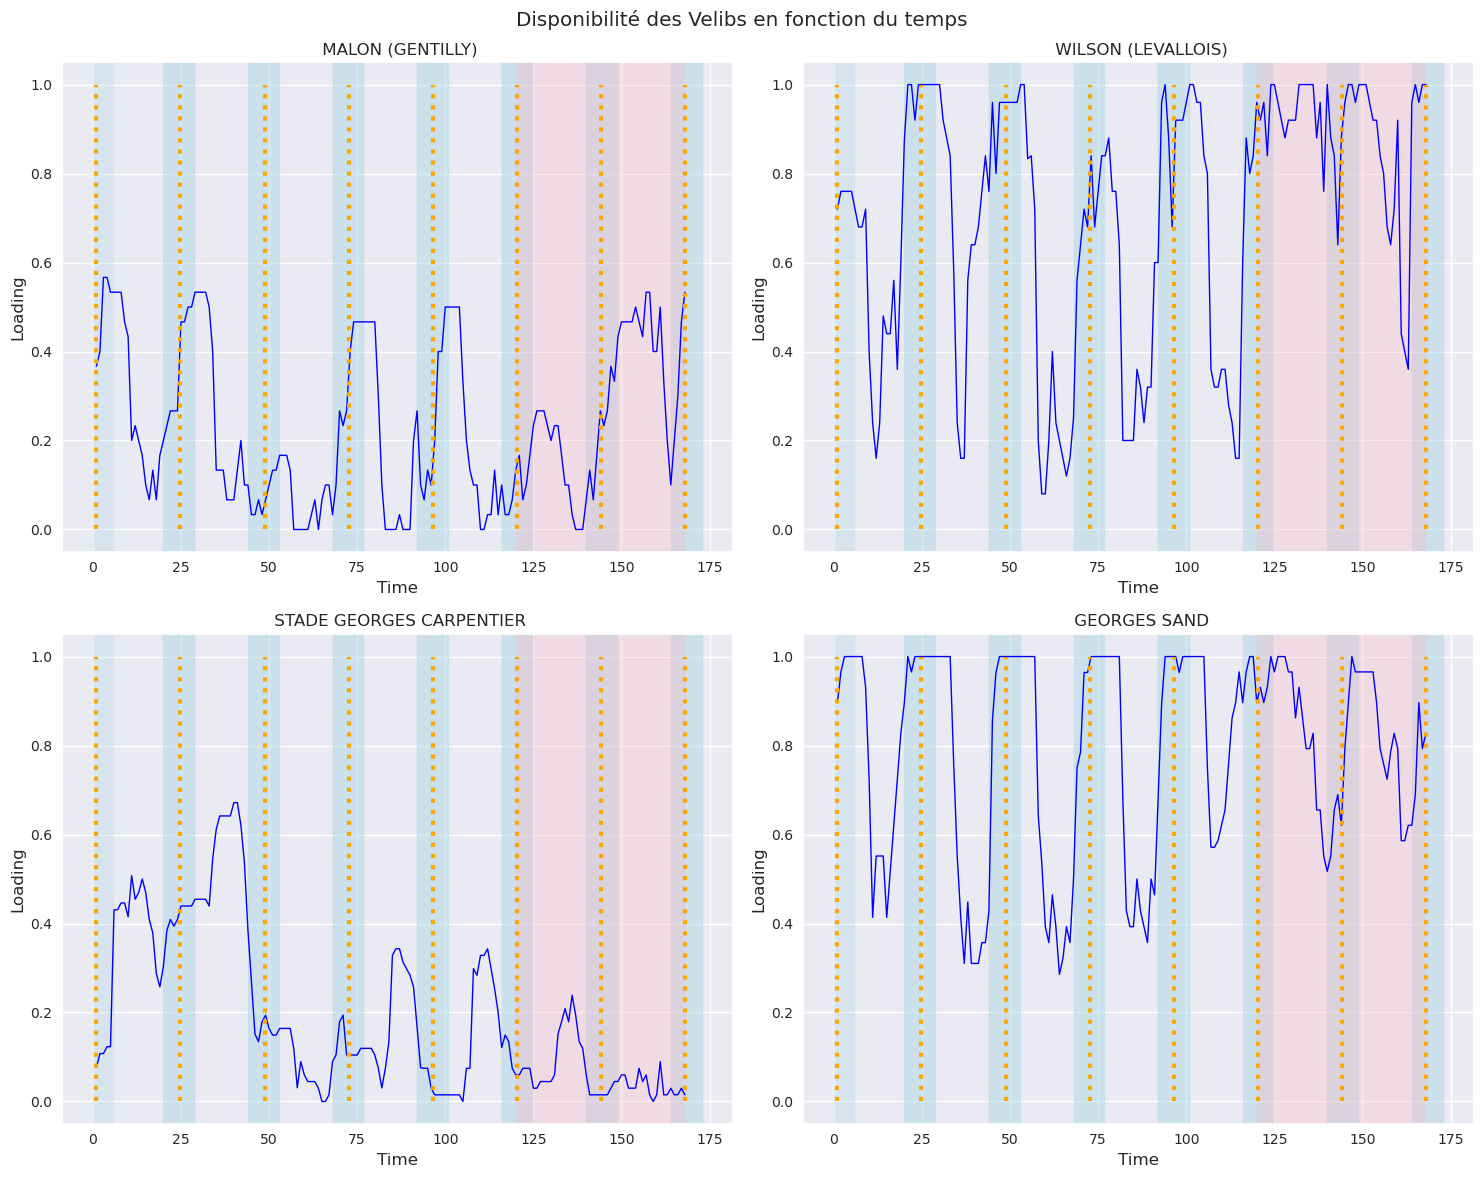

In [772]:
stations = np.arange(loading.shape[0])
rd.shuffle(stations)
stations = stations[:4]

loading_data = loading.to_numpy()

n_steps = loading.shape[1]  # number of observed time steps
time_range = np.linspace(1, n_steps, n_steps)  # observed time range
time_tick  = np.linspace(1, n_steps, 8)  # beginning of days


fig, axs = plt.subplots(2, 2, figsize = (15,12))



for i in range(2):
    for j in range(2):
        k_station = stations[2 * i + j]
        axs[i, j].plot(time_range, loading_data[k_station, :], linewidth = 1, color = "blue")
        axs[i, j].vlines(x = time_tick, ymin = 0, ymax = 1, colors = "orange", linestyle = "dotted", linewidth = 3)
        axs[i, j].set_title(coord.names[1 + k_station], fontsize = 12)
        
        
for ax in axs.flat:
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Loading', fontsize = 12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.axvspan(0,6, color='lightblue', alpha=0.3)
    for i in range(n_steps):
        if i % 24 == 20:
            ax.axvspan(i,i+9, color='lightblue', alpha=0.5)
    ax.axvspan(120,168, color='lightpink', alpha=0.3) # tres visible sur canal saint denis
            
fig.suptitle("Disponibilité des Velibs en fonction du temps")    
plt.tight_layout()
plt.show()


On déduit des graphes de la disponibilité des Vélibs en fonction du temps qu'il semble apparaître une tendance de remplissage différente entre le jour et la nuit, plus particulièrement en fonction des plages horaires. Les pics de remplissage paraissent suivre une tendance périodique chaque jour. L'heure et la localisation de la station semblent être des facteurs importants impliqués dans le remplissage des stations. En effet, dans certaines stations la nuit il n'y a jamais de Vélibs et dans d'autre il y en a toujours.

De même, on repère sur cette analyse descriptive du remplissage des stations des comportements différents pour certaines stations entre les intervalles de temps de la semaine et ceux du weekend (heure située entre 120 et 168, en rouge sur le graphe). 

Enfin, on souligne également une certaine disparité de comportement des stations.

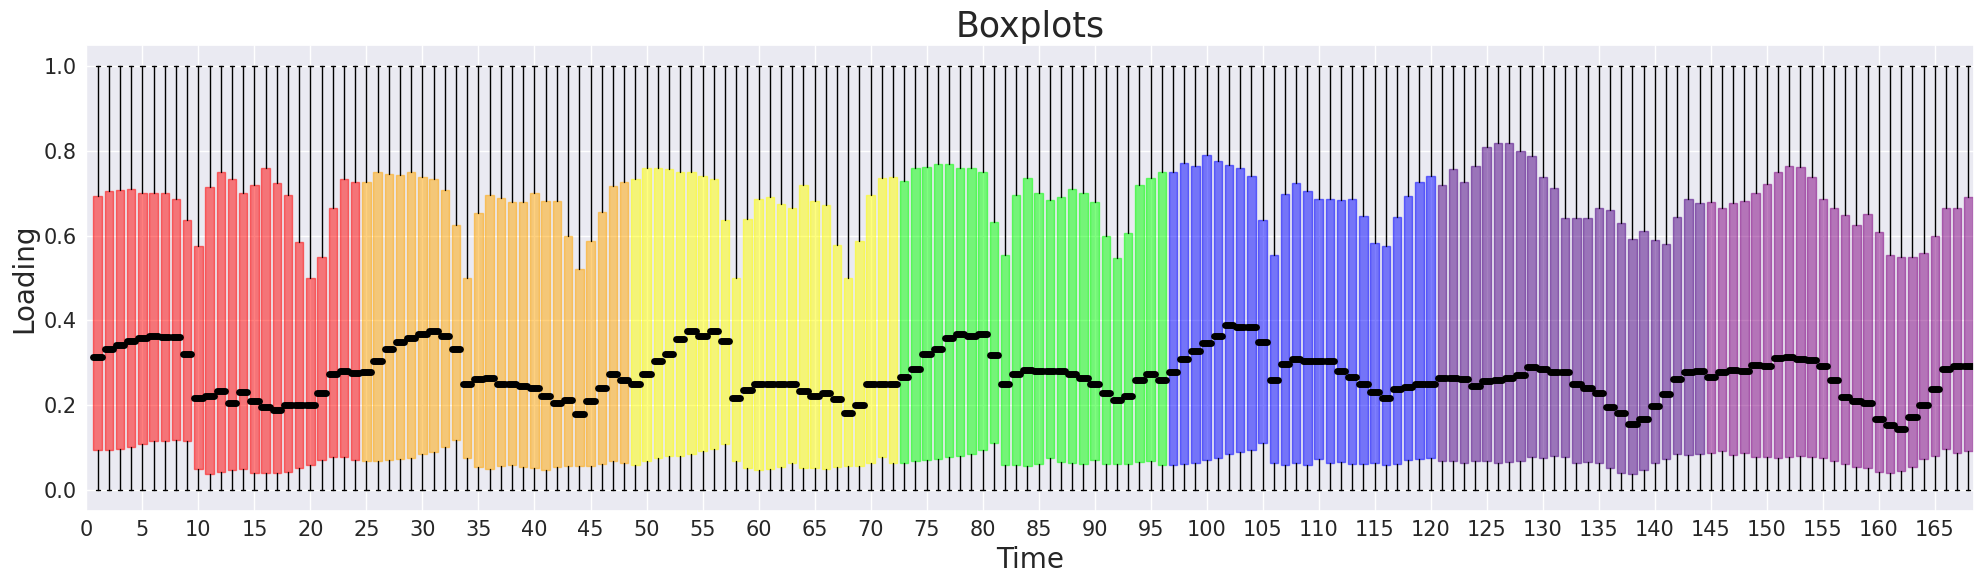

In [773]:
plt.figure(figsize = (20,6))

# --- #

bp = plt.boxplot(loading_data, widths = 0.75, patch_artist = True)

for box in bp['boxes']:
    box.set_alpha(0.8)

for i,box in enumerate(bp['boxes']):
    box.set_alpha(0.5)
    if i//24 ==0:
        box.set_color('#FF0000')
    elif i//24 ==1:
        box.set_color('#FFA500')
    elif i//24 ==2:
        box.set_color('#FFFF00')
    elif i//24 ==3:
        box.set_color('#00FF00')
    elif i//24 ==4:
        box.set_color('#0000FF')
    elif i//24 ==5:
        box.set_color('#4B0082')
    else:
        box.set_color('#800080')
    
for median in bp['medians']:
    median.set(color = "black", linewidth=5)
    
# --- #
    
#plt.vlines(x = time_tick, ymin = 0, ymax = 1, 
#           colors = "black", linestyle = "dotted", linewidth = 5)

# --- #

plt.xlabel('Time', fontsize = 20)
plt.ylabel('Loading', fontsize = 20)
plt.title("Boxplots", fontsize = 25)
plt.xticks(ticks = np.arange(0, 168, 5), labels=np.arange(0, 168, 5), fontsize = 15)
plt.yticks(fontsize = 15)

plt.tight_layout()
plt.show()





Le tracé du bloxplot sur les données confirme le caractère périodique que nous prêtions au remplissage des stations : le comportement des stations dépend du jour de la semaine (ouvré ou non) et du moment dans la journée. De plus, les données ne sont pas symétriques puisque les médianes ne se situent pas au milieu du boxplot, et varient selon les heures entre 0.2 et 0.4.
On remarque que toutes les variables ne sont pas à la même échelle. Ce qui traduit le fait que le remplissage ne suit pas la meme distribution selon l'heure et le jour. 

On observe bien qu'il n'y a que des valeurs comprises entre 0 et 1 ce qui est cohérent pour un ratio.

Cependant, le boxplot ci-dessus ne suffit pas à déterminer s'il existe un comportement moyen pour les stations ou si la variabilité entre les stations est importante.

--- Average fill rate ---
0.3816217759807477

--- Least crowded station, on average ---
Average fill rate : 0.016132842025699153
longitude              2.427934
latitude              48.873929
bonus                         1
names         HORNET (BAGNOLET)
Name: 997, dtype: object

--- Fullest station, on average ---
Average fill rate : 0.9193722943722953
longitude                          2.398262
latitude                           48.81466
bonus                                     0
names         INSURRECTION AOUT 1944 (IVRY)
Name: 1107, dtype: object


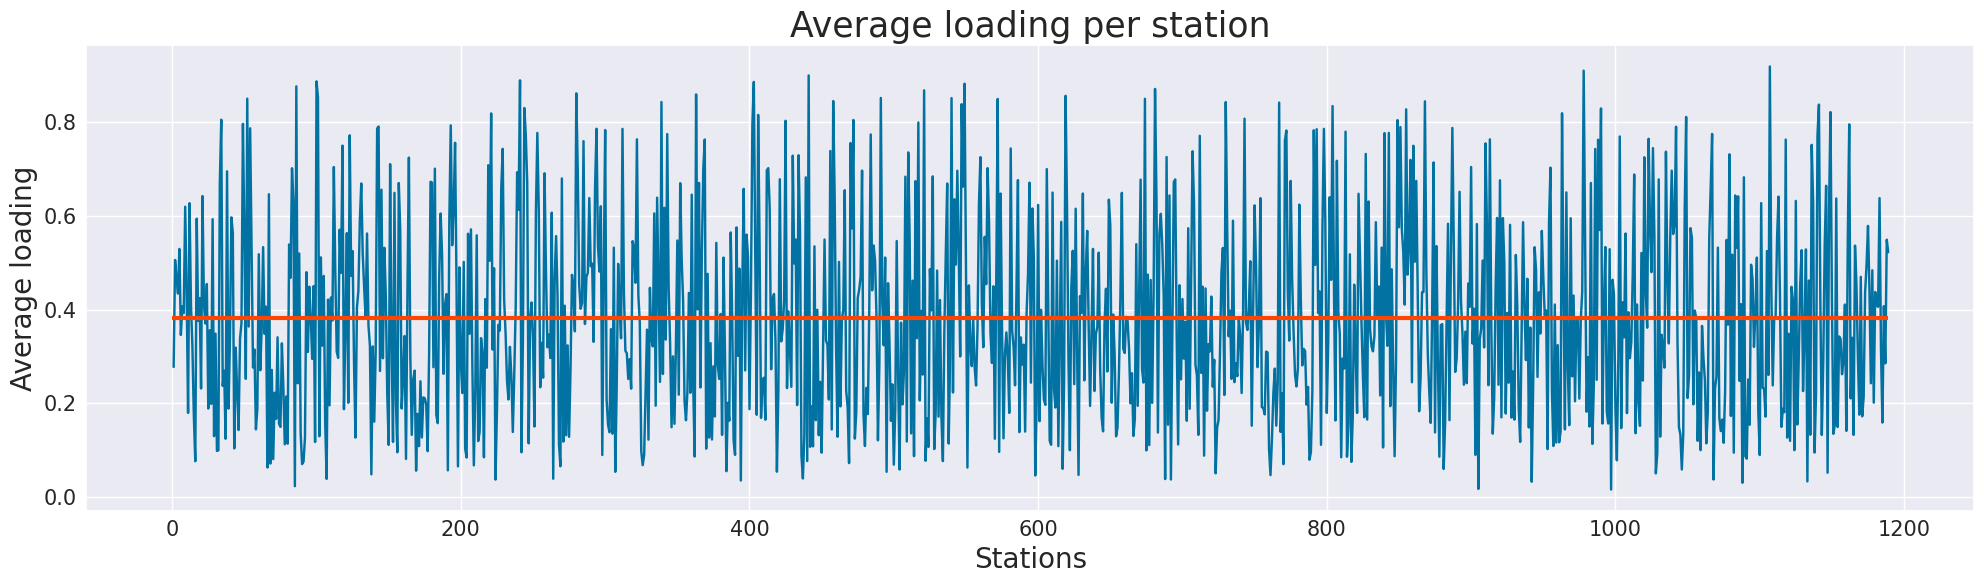

In [774]:
print('--- Average fill rate ---')
print(loading.mean().mean())

# --- #
print('')

loading_mean = pd.Series(loading.mean(axis=1))

print('--- Least crowded station, on average ---')
i = loading_mean.idxmin()
print('Average fill rate :',loading_mean[i])
print(coord.loc[i])

# --- #
print('')

print('--- Fullest station, on average ---')
i = pd.Series(loading.mean(axis=1)).idxmax()
print('Average fill rate :',loading.mean(axis=1)[i])
print(coord.loc[i])

n_stations = loading.shape[0]  # number of observed stations
stations   = np.arange(n_stations)

plt.figure(figsize = (20,6))

# --- #

plt.plot(loading_mean)
plt.hlines(y = loading.mean().mean(), xmin=0, xmax=n_stations, 
           colors = "OrangeRed", linewidth = 3)

# --- #

plt.xlabel('Stations', fontsize = 20)
plt.ylabel('Average loading', fontsize = 20)
plt.title("Average loading per station", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.show()

On identifie une grande disparité de valeurs entre les stations. Toutefois, il serait intéressant par la suite d'étudier si le comportement des stations dépend des variables longitude, latitude et bonus du dataframe "coord". La valeur moyenne du remplissage vaut 0.38, ce qui signifie qu'il y a une moyenne de 38% de remplissage des stations. On a visualisé d'une meilleure manière le comportement spécifique en modélisant le remplissage en fonction des stations avec le graphe ci-dessus.

Afin de déterminer plus clairement l'impact de l'heure sur la distribution des stations, on se concentre sur le tracé du remplissage heure par heure sans distinction des jours sur toute la durée de l'étude.

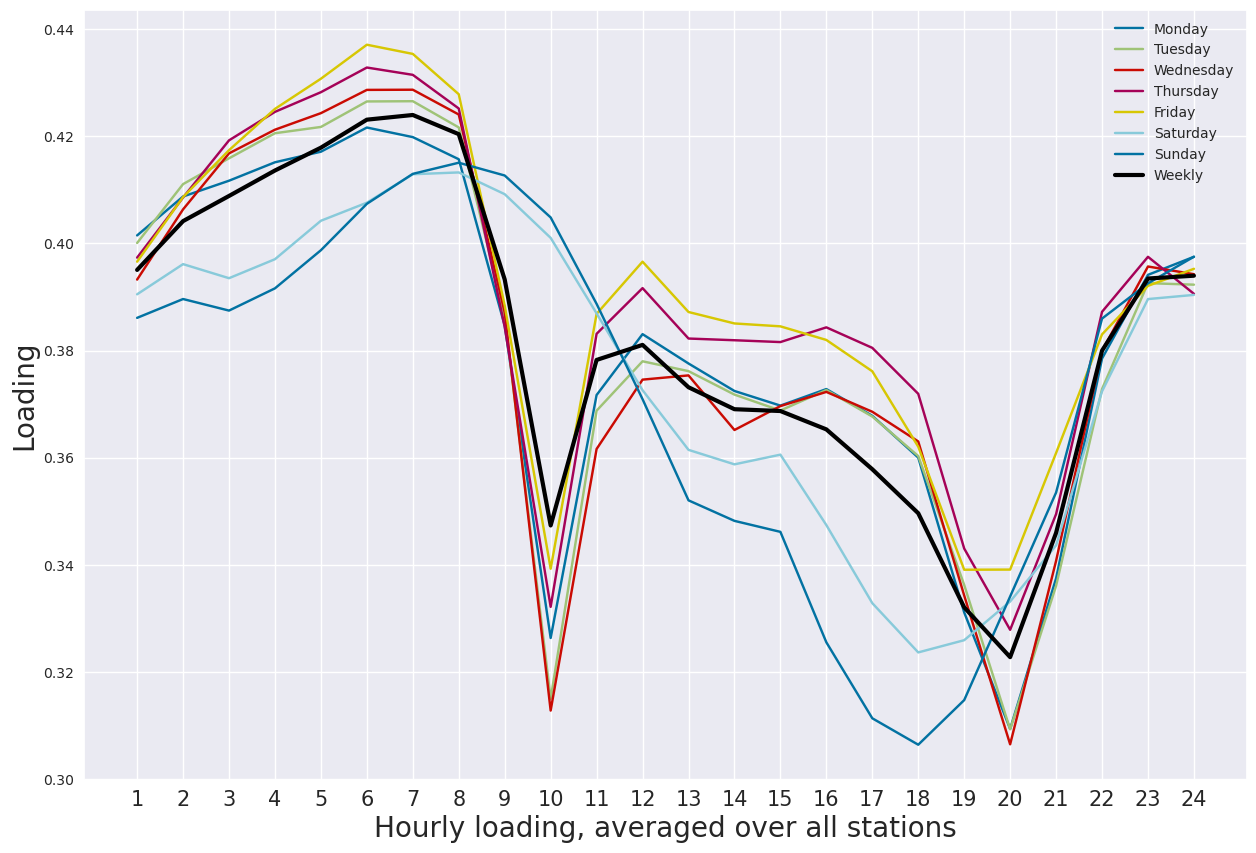

In [775]:
mean_per_hour_per_day = loading.mean(axis = 0).to_numpy()
mean_per_hour_per_day = mean_per_hour_per_day.reshape((7, 24))

mean_per_hour = mean_per_hour_per_day.mean(axis=0)

# --- #

days = ["Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize = (15,10))

plt.plot(np.arange(1,25), mean_per_hour_per_day.transpose())
plt.plot(np.arange(1,25), mean_per_hour, color = "black", linewidth = 3)

plt.xlabel('Hourly loading, averaged over all stations', fontsize = 20)
plt.ylabel('Loading', fontsize = 20)
plt.legend(days + ['Weekly'])
plt.xticks(ticks = np.arange(1,25), labels=np.arange(1,25), fontsize = 15)
  
plt.tight_layout
plt.show()

Ci-dessus nous retrouvons l'évolution heure par heure du remplissage, et ce pour chaque jour de la semaine étudiée. En noir, nous avons la moyenne heure par heure pour tous les jours. Un motif se distingue nettement pour l'ensemble des stations pour des plages horaires spécifiques. Nous pouvons tirer comme information que les cinq premiers jours de la semaine ont une allure plutôt similaire. En semaine, on repère de grandes variations de remplissage entre 8h et 11h et entre 18h et 22h. Par la suite il sera judicieux de séparer la semaine en deux : jours ouvrés et weekend.

In [776]:
from ipywidgets import interact, IntSlider, Dropdown

# Ne pas mettre Sunday 24h

# Définition des heures et des jours ainsi que de la taille des graphes
hours = np.arange(0, 24)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
s, n = 10, len(hours)

# Création de la fonction qui génère le graphique en fonction de l'heure et du jour choisis
def plot_hour_day(hour, day):
    fig, ax = plt.subplots(figsize=(s, s))
    im = ax.scatter(coord.longitude, coord.latitude, c=loading_data[:, hour + 24*(days.index(day))], cmap=cm.plasma_r)
    ax.set_title('Stations loading - {} {} h'.format(day, hour), fontsize=25)
    ax.set_xlabel('Longitude', fontsize=20)
    ax.set_ylabel('Latitude', fontsize=20)
    ax.tick_params(axis='both', labelsize=15)
    plt.colorbar(im, ax=ax)
    plt.show()


# Création de l'interface interactive avec deux curseurs pour choisir l'heure et le jour
interact(plot_hour_day, hour=IntSlider(min=1, max=24, step=1, value=1), day=Dropdown(options=days, value='Monday', description='Day:'))

interactive(children=(IntSlider(value=1, description='hour', max=24, min=1), Dropdown(description='Day:', opti…

<function __main__.plot_hour_day(hour, day)>


On remarque que la fréquentation des stations semble éparse, surtout de minuit à 10h. Cependant on parvient déjà à dégager certains motifs caractéristiques en fonction des plages horaires. En effet, la semaine de 10h (14h pour le week-end) à 20h environ, on remarque un fort contraste de fréquentation. D'une part la partie Nord des stations et une petite partie au Sud autour de 2.3 de longitude, où pratiquement tous les vélos ont été empruntés. D'autre part il apparait un arc qui regroupe la plupart des stations où tous les vélos sont disponibles en journée. Cela pourrait s'interpréter par les usages clients liés aux mobilités du travail ou de la vie active. A l'inverse, on repère un autre comportement différent dans la fréquentation de stations à partir de 20h jusqu'à minuit. Certaines stations qui sont pratiquement vides en journée redeviennent en grande partie disponible. Enfin, les mercredis, jeudis et vendredis, de 4h à 6h on observe une diagonale partant du Nord-Ouest jusqu'au Sud-Est où les stations sont vides.


## Analyse d'individus spécifiques : le cas particulier de stations situés sur des collines

Portons désormais une attention particulière à la variable binaire 'bonus' du jeu de données Coord. Cette variable nous indique si la station se situe sur une colline (bonus==1) ou non. Remarquons que la station dont le remplissage était le moins important se situait sur une colline. Il serait, de ce fait, intéressant de relever si les stations présentant cette caractéristique particulière se comportent différemment des autres stations. Cela nous donnera un premier indice sur l'impact de la géographie des stations sur les flux de Velibs et les usages qui lui sont spécifiques.

In [777]:
coord['hill'] = coord['bonus'].astype('category') # convert to categorical

# --- #

fig = px.scatter_mapbox(coord, lat = 'latitude', lon = 'longitude',
mapbox_style = "carto-positron",
color = 'hill',
color_discrete_map = {0:'midnightblue', 1:'plum'},
labels = {0: "hello", 1: "hi"},
zoom = 10, opacity = .9,
title = 'Hilltop stations')

fig.show()

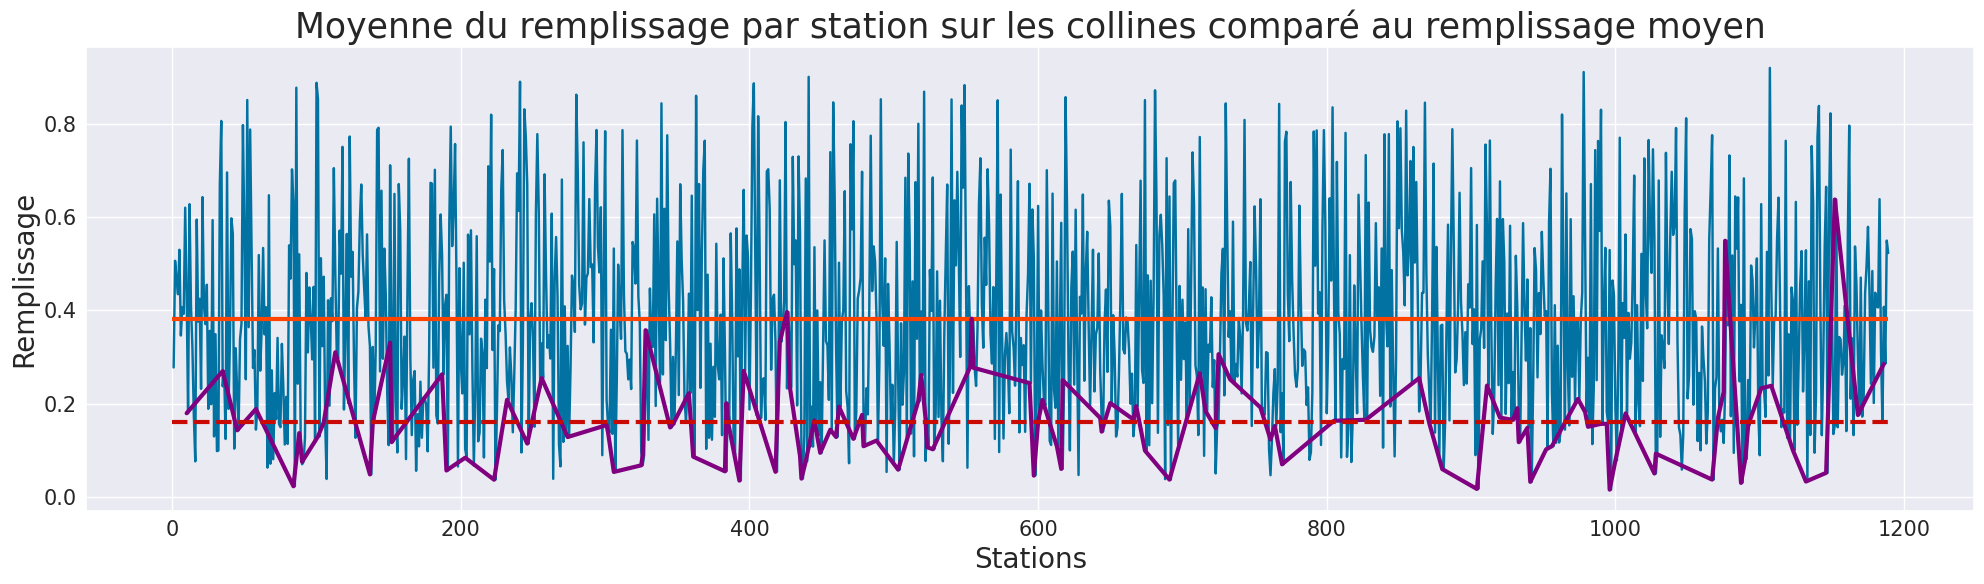

0.16104660259524076


In [778]:
coord_data = coord.to_numpy()
index_hill = []
for i in range(len(coord_data)):
    if coord_data[i][-3] == 1:
        index_hill.append(i)
index_hill = np.array(index_hill)

index_not_hill = []
for i in range(len(coord_data)):
    if coord_data[i][-3] == 0:
        index_not_hill.append(i)
index_not_hill = np.array(index_not_hill)

loading_hill = loading_data[index_hill]

loading_hill_mean = pd.Series(loading_hill.mean(axis=1))

n_stations = loading.shape[0] 
stations = np.arange(n_stations)

plt.figure(figsize = (20,6))

# --- #

plt.plot(loading_mean)
plt.hlines(y = loading.mean().mean(), xmin=0, xmax=n_stations,
colors = "OrangeRed", linewidth = 3)

plt.plot(index_hill,loading_hill_mean, color = 'purple', linewidth = 3)
plt.hlines(y = loading_hill_mean.mean().mean(), xmin=0, xmax=n_stations,
colors = "r", linewidth = 3, linestyles = '--')

# --- #

plt.xlabel('Stations', fontsize = 20)
plt.ylabel('Remplissage', fontsize = 20)
plt.title("Moyenne du remplissage par station sur les collines comparé au remplissage moyen", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.tight_layout()
plt.show()

print(loading_hill_mean.mean().mean())

Le graphe ci-dessus représentant la moyenne de remplissage sur les stations sur les collines met en lumière le fait que les stations ayant cette caractéristique ont en moyenne tendance à être beaucoup moins remplies que la moyenne des stations. La valeur moyenne de remplissage des stations sur les collines se situe en moyenne autour de 0.16 contre 0.38 pour la moyenne toutes stations confondues, soit pratiquement deux fois moins. On peut donc déduire un usage différents des Velibs en haut des collines. On peut conjecturer que les usagers fréquentent moins les stations sur les collines que la moyenne des stations globalement.

In [779]:
from ipywidgets import interact, IntSlider, Dropdown

# Ne pas mettre Sunday 24h

# Définition des heures et des jours ainsi que de la taille des graphes
hours = np.arange(0, 24)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
s, n = 10, len(hours)

# Création de la fonction qui génère le graphique en fonction de l'heure et du jour choisis
def plot_hour_day(hour, day):
    fig, ax = plt.subplots(figsize=(s, s))
    copy_hill = np.copy(loading_data)
    copy_not_hill = np.copy(loading_data)
    for i in range(len(loading_data)):
        if i not in index_hill:
            copy_hill[i] = None
        else:
            copy_not_hill[i] = None
    im1 = ax.scatter(coord.longitude, coord.latitude, c=copy_hill[:, hour + 24*(days.index(day))], cmap='Oranges')
    im2 = ax.scatter(coord.longitude, coord.latitude, c=copy_not_hill[:, hour + 24*(days.index(day))], cmap='Blues')
    ax.set_title('Stations loading - {} {} h'.format(day, hour), fontsize=25)
    ax.set_xlabel('Longitude', fontsize=20)
    ax.set_ylabel('Latitude', fontsize=20)
    ax.tick_params(axis='both', labelsize=15)
    plt.colorbar(im1, ax=ax)
    plt.colorbar(im2, ax=ax)
    plt.show()


# Création de l'interface interactive avec deux curseurs pour choisir l'heure et le jour
interact(plot_hour_day, hour=IntSlider(min=1, max=24, step=1, value=1), day=Dropdown(options=days, value='Monday', description='Day:'))

interactive(children=(IntSlider(value=1, description='hour', max=24, min=1), Dropdown(description='Day:', opti…

<function __main__.plot_hour_day(hour, day)>

De cette première étude des données, on retient que des tendances se dégagent selon la zone géographique des stations : stations au centre ville ou en altitude. De plus, le comportement des utilisateurs n'est pas le meme pour un jour ouvré ou non. Ceci est une bonne intuition des différents profils qui se dégageront de notre analyse.

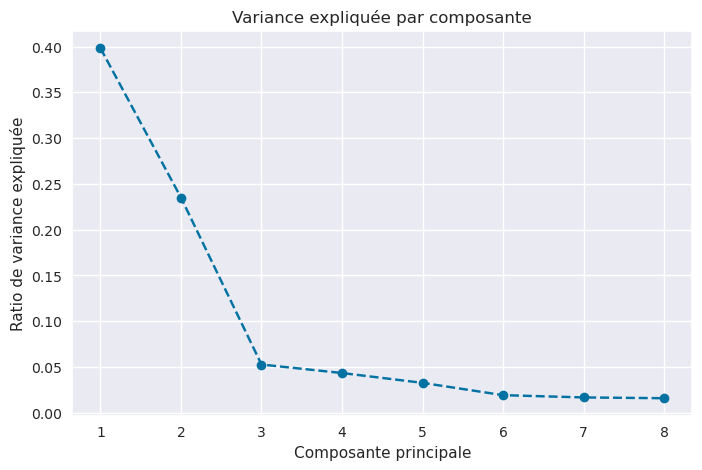

In [780]:
pca = PCA()
df=loading
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Ajustement du PCA sur les données
pca.fit(df_scaled)

# Tracé du graphe de l'inertie des composantes principales
plt.figure(figsize=(8, 5))
plt.plot(range(1,9), pca.explained_variance_ratio_[:8], marker='o', linestyle='--')
plt.title('Variance expliquée par composante')
plt.xlabel('Composante principale')
plt.ylabel('Ratio de variance expliquée')
plt.xticks(range(1, 9))
plt.grid(True)
plt.show()


Bien que la méthode du coude semblerait suggerer qu'il faudrait seulement 3 composantes, nous garderons 5 composantes pour réunir autour de 80% de l'inertie des données (on remarque qu'à partir de la 6e composante l'inertie par composante reste relativement constante et négligeable).

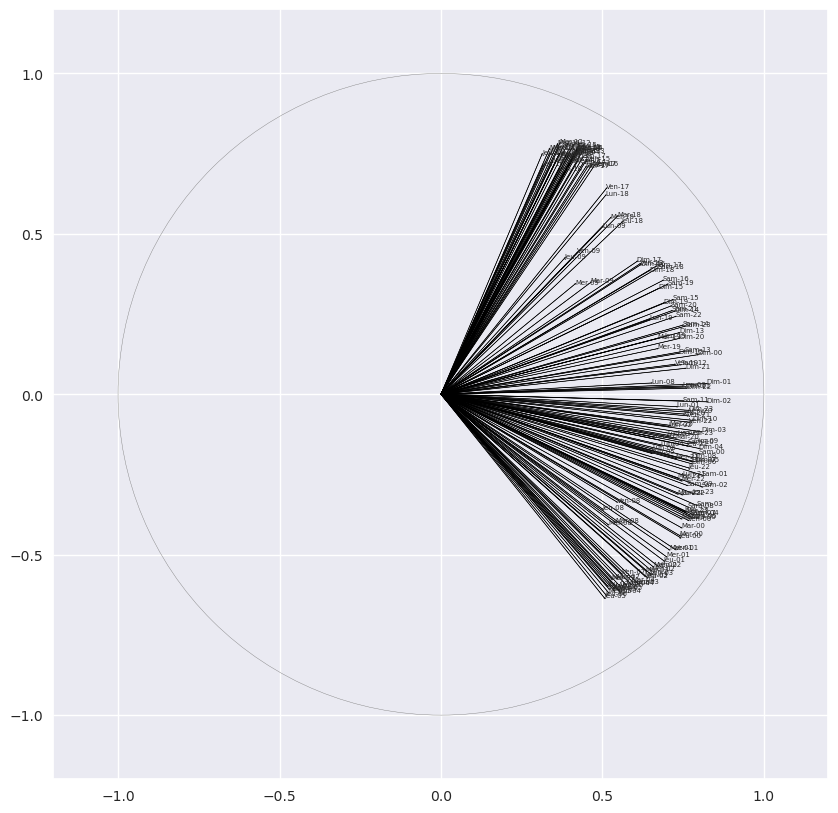

In [781]:
df= loading
# Standardisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
# Initialisation de l'objet PCA
pca = PCA()
# Ajustement du PCA sur les données
pca.fit(df_scaled)


coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, loading.columns):
    plt.text(i, j, nom, fontsize = 5)
    plt.arrow(0,0,i,j,color='black')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)
plt.show()

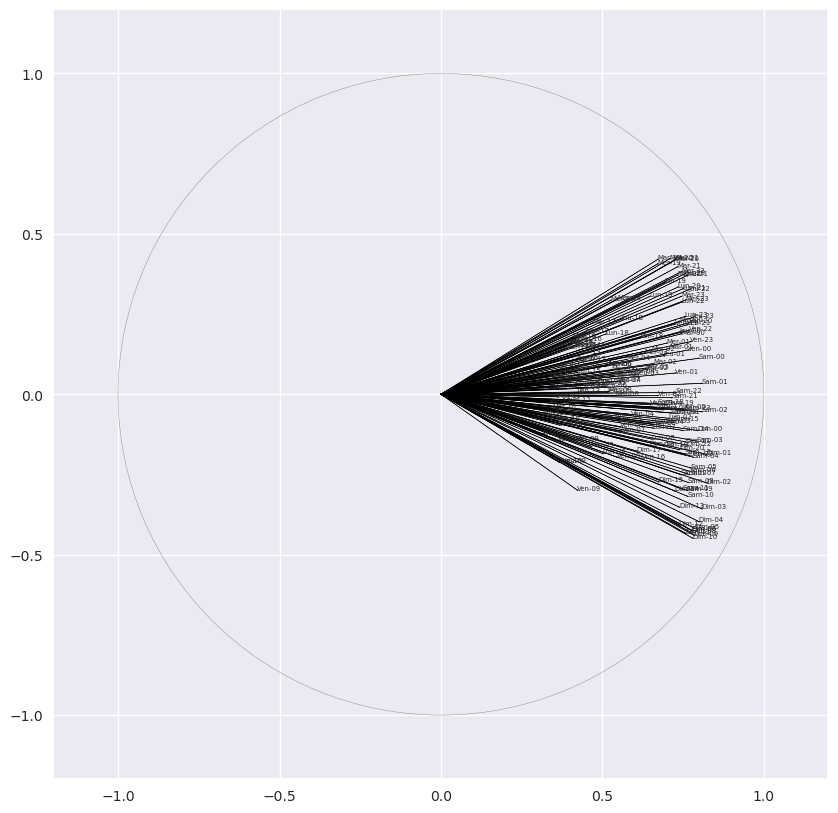

In [782]:
df= loading # AJOUTER LEGENDE GRAPHE
# Standardisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
# Initialisation de l'objet PCA
pca = PCA()
# Ajustement du PCA sur les données
pca.fit(df_scaled)


coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[3]*np.sqrt(pca.explained_variance_[3])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, loading.columns):
    plt.text(i, j, nom, fontsize = 5)
    plt.arrow(0,0,i,j,color='black')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)
plt.show()

Les projections des variables dans les différents plans factoriels sont illisibles. Comme il s'agit de variables temporelles nous allons tracer leur corrélation en fonction de chaque dimension.

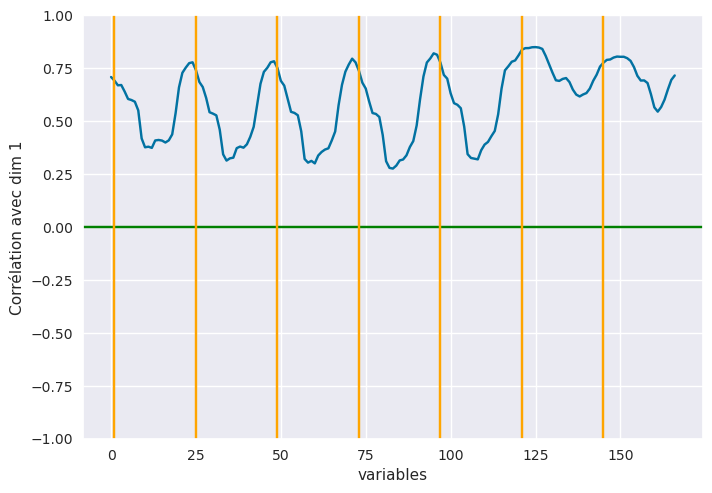

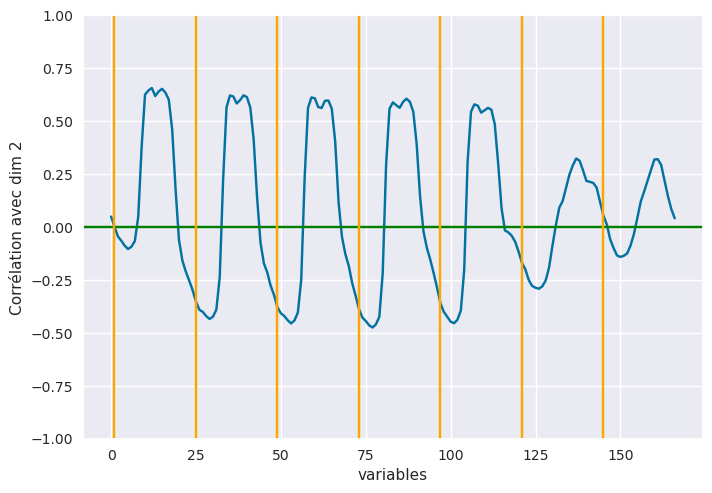

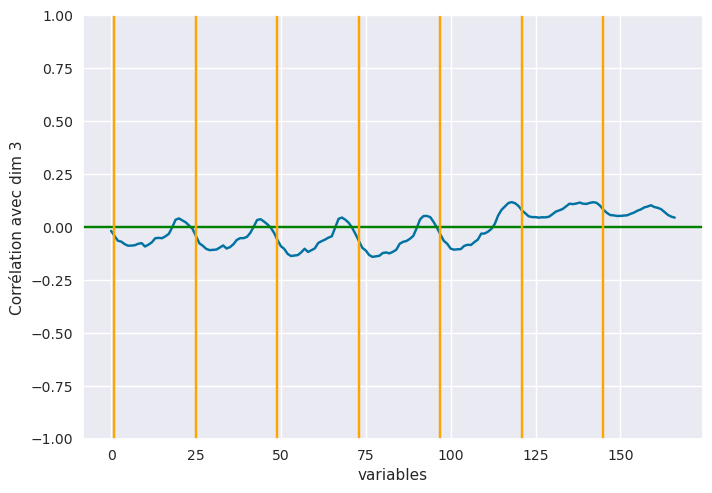

In [783]:
time_tick = [1 + 24 * i for i in range(7)]  # Vecteur délimitant les jours

# Exemple de données fictives pour pca$var$coord
df = np.copy(loading)
pca = PCA().fit(df)

for i in range(3):
    plt.figure()
    plt.plot(pca.components_[i,:-1]*pca.explained_variance_[i])
    plt.xlabel("variables")
    plt.ylabel("Corrélation avec dim " + str(i + 1))
    plt.ylim(-1, 1)
    plt.axhline(0, color='green')
    for tick in time_tick:
        plt.axvline(tick, color='orange')
    plt.show()


In [784]:
def group_variable_colors(variable_names, group_size):
    colors = sns.color_palette("husl", n_colors=(len(variable_names) // group_size) + 1)
    groups = [i // group_size for i in range(len(variable_names))]
    group_colors = {group: color for group, color in zip(set(groups), colors)}
    return [group_colors[group] for group in groups], group_colors

def group_variable_labels(variable_names, group_size):
    labels = []
    for i in range(0, len(variable_names), group_size):
        group_labels = ', '.join(variable_names[i:i+group_size])
        labels.append(group_labels)
    return labels

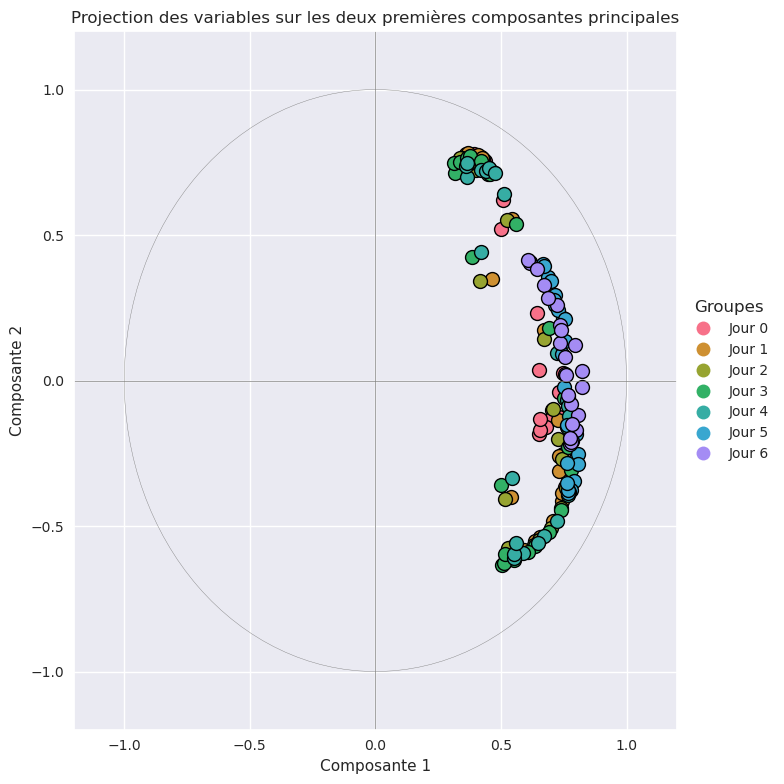

In [785]:
def group_variable_colors(variable_names, group_size):
    colors = sns.color_palette("husl", n_colors=(len(variable_names) // group_size) + 1)
    groups = [i // group_size for i in range(len(variable_names))]
    group_colors = {group: color for group, color in zip(set(groups), colors)}
    return [group_colors[group] for group in groups], group_colors

def group_variable_labels(variable_names, group_size):
    labels = []
    for i in range(0, len(variable_names), group_size):
        group_labels = ', '.join(variable_names[i:i+group_size])
        labels.append(group_labels)
    return labels

# Création d'un DataFrame de test
df = loading

# Standardisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Initialisation de l'objet PCA
pca = PCA()

# Ajustement du PCA sur les données
pca.fit(df_scaled)

# Graphe des variables projetées

colors, group_colors = group_variable_colors(df.columns, 24)
group_labels = group_variable_labels(df.columns, 24)

# Calcul des coordonnées des variables sur les deux premières composantes principales
coord1 = pca.components_[0] * np.sqrt(pca.explained_variance_[0])
coord2 = pca.components_[1] * np.sqrt(pca.explained_variance_[1])

# Création de la figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

# Coloration des variables et affichage de leurs projections sur les deux premières composantes principales avec un contour noir
for i, (x, y) in enumerate(zip(coord1, coord2)):
    ax.scatter(x, y, color=colors[i], edgecolor='black', linewidth=1, s=100)

# Ajout de l'étiquette correspondant à chaque groupement dans la légende
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markeredgecolor='black', markersize=10, label=f'Jour {group}') for group, color in group_colors.items()]
plt.legend(handles=legend_handles, title='Groupes', loc='center left', bbox_to_anchor=(1, 0.5))

# Ajout du cercle
c = plt.Circle((0, 0), radius=1, color='gray', fill=False)
ax.add_patch(c)

# Définition des limites des axes
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

# Ajout des lignes et titres
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.title('Projection des variables sur les deux premières composantes principales')
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.grid(True)
plt.tight_layout()

# Affichage du graphe
plt.show()



Nous décidons de tracer le plan factoriel (dim1,dim2), dans lequel l'intégralité des variables temporelles semble bien représentée. On remarque que toutes les variables sont corrélées positivement avec la composante 1. Cette composante mesure donc le niveau global de remplissage des stations. De plus, si l'on identifie les variables en fonction des heures de la journée à laquelles elles correspondent, nous pouvons interpréter plus clairement la composante 2. C'est pourquoi nous allons désormais tracer la projection des variables colorées en fonction des heures de la journée.





#A SUPPRIMER La composante 1 semble davantage bien représenter les variables correspondant aux plages horaires du weekend. En revanche, la compoosante 2 semble tres mal representer ces variables ci, et beaucoup plus corrélées avec le reste de la semaine.

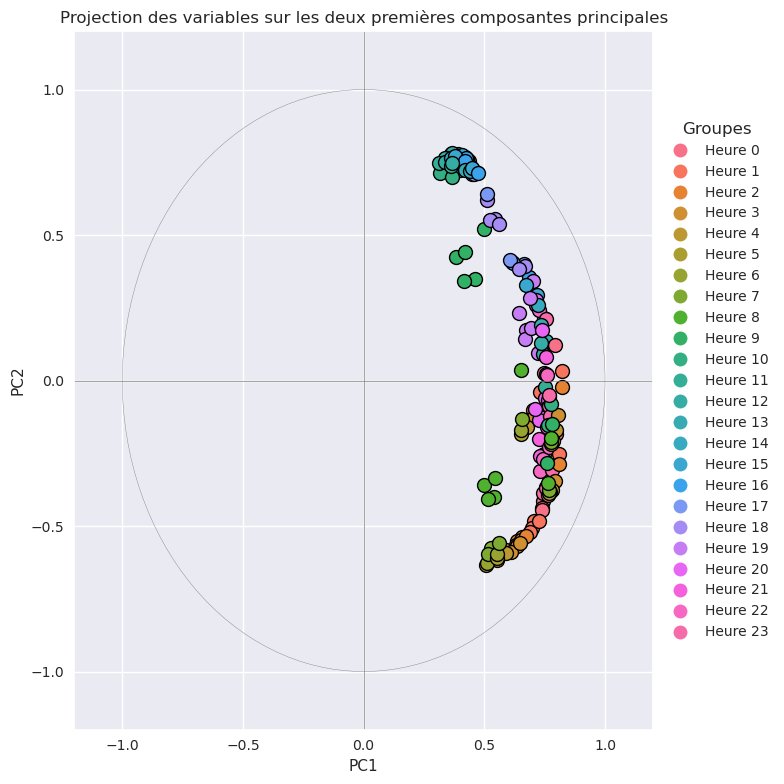

In [786]:
def group_variable_colors(variable_names):
    colors = sns.color_palette("husl", n_colors=24)
    groups = [i % 24 for i in range(len(variable_names))]
    group_colors = {group: color for group, color in zip(set(groups), colors)}
    return [group_colors[group] for group in groups], group_colors

# Création d'un DataFrame de test
df = loading

# Standardisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Initialisation de l'objet PCA
pca = PCA()

# Ajustement du PCA sur les données
pca.fit(df_scaled)

# Calcul des coordonnées des variables sur les deux premières composantes principales
coord1 = pca.components_[0] * np.sqrt(pca.explained_variance_[0])
coord2 = pca.components_[1] * np.sqrt(pca.explained_variance_[1])

# Création de la figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

# Coloration des variables et affichage de leurs projections sur les deux premières composantes principales avec un contour noir
colors, group_colors = group_variable_colors(df.columns)
for i, (x, y) in enumerate(zip(coord1, coord2)):
    ax.scatter(x, y, color=colors[i], edgecolor='black', linewidth=1, s=100)

# Ajout de l'étiquette correspondant à chaque groupement dans la légende
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markeredgecolor='black', markersize=10, label=f'Heure {group}') for group, color in group_colors.items()]
plt.legend(handles=legend_handles, title='Groupes', loc='center left', bbox_to_anchor=(1, 0.5))

# Ajout du cercle
c = plt.Circle((0, 0), radius=1, color='gray', fill=False)
ax.add_patch(c)

# Définition des limites des axes
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

# Ajout des lignes et titres
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.title('Projection des variables sur les deux premières composantes principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.tight_layout()

# Affichage du graphe
plt.show()

La visualisation des variables selon les heures permet de constater que l'heure de la journée est un facteur crucial dans le signe de la corrélation des variables. Les variables du jour et correspondant à de horaires de travail semblent corrélées davantage positivement notamment. La composante 2 parait alors représenter les usages de journée et de la nuit, et les dynamiques des Velibs liées à l'heure de la journée.

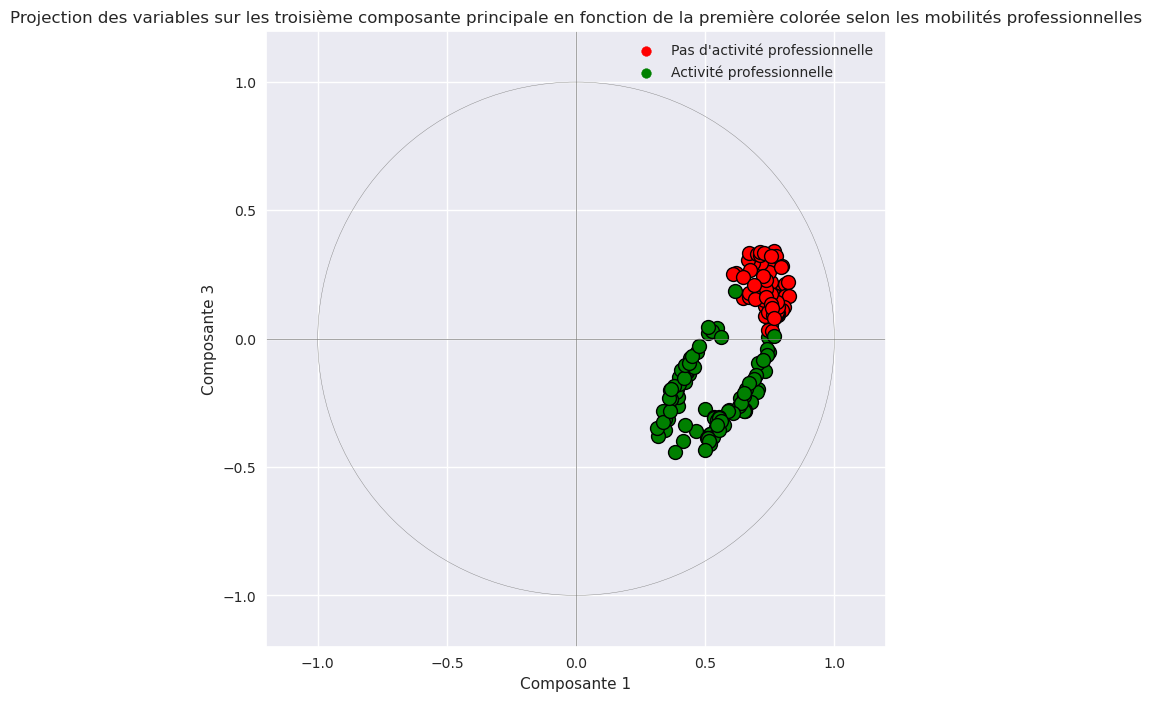

In [787]:

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df) # on retire la derniere valeur car la variable dimanche 24h renvoie des valeurs aberrantes

# Initialisation de l'objet PCA et ajustement sur les données
pca = PCA().fit(df_scaled)

# Calcul des coordonnées des variables sur les deux premières composantes principales
coord1 = pca.components_[0] * np.sqrt(pca.explained_variance_[0])
coord3 = pca.components_[2] * np.sqrt(pca.explained_variance_[2])

# Création de la figure
plt.figure(figsize=(8, 8))

# Variables à mettre en évidence
vacances_indices = set(range(120, 169)).union(set(filter(lambda x: x % 24 in range(19, 24), range(len(df.columns)))))

# Définition des couleurs
vacances_color = 'red'
rest_color = 'green'

# Affichage des points et coloration
for i, (x, y) in enumerate(zip(coord1, coord3)):
    color = vacances_color if i in vacances_indices else rest_color
    plt.scatter(x, y, color=color, edgecolor='black', linewidth=1, s=100)

# Ajout du cercle
circle = plt.Circle((0, 0), radius=1, color='gray', fill=False)
plt.gca().add_artist(circle)

# Définition des limites des axes
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

# Ajout des lignes et titres
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.title('Projection des variables sur les troisième composante principale en fonction de la première colorée selon les mobilités professionnelles')
plt.xlabel('Composante 1')
plt.ylabel('Composante 3')
plt.grid(True)

# Ajout de la légende
plt.legend(handles=[plt.scatter([], [], color='red', label='Pas d\'activité professionnelle'),
plt.scatter([], [], color='green', label='Activité professionnelle')],
title='')

# Affichage du graphe
plt.show()

En projetant les variables sur les composantes 1 et 3, on remarque que bien que la composante 3 ne soit associée qu'à une petite partie de l'inertie et ne pas parfaitement bien représenter les données, elle semble assez nettement traduire les différences des usages de Velibs entre les jours du weekend et de la semaine.

En effet, les variables correspondant aux plages horaires du weekend semblent corrélées positivement avec la composante 3, tandis que les variables de la semaines ouvrée ont tendance à se corréler négativement.

Les variables correspondant au samedi, au dimanche, et les jours ouvrés de 19h à 23h ont toutes une corrélation négative avec la composante 3. Ces horaires semblent liés aux mobilités hors cadre professionnel. Au contraire, les variables correspondant aux jours ouvrés de 0h à 19h semblent corrélées positivement avec la dimension 3. Elle représente donc le profil des utilisations des Velibs hors cadre professionnel.



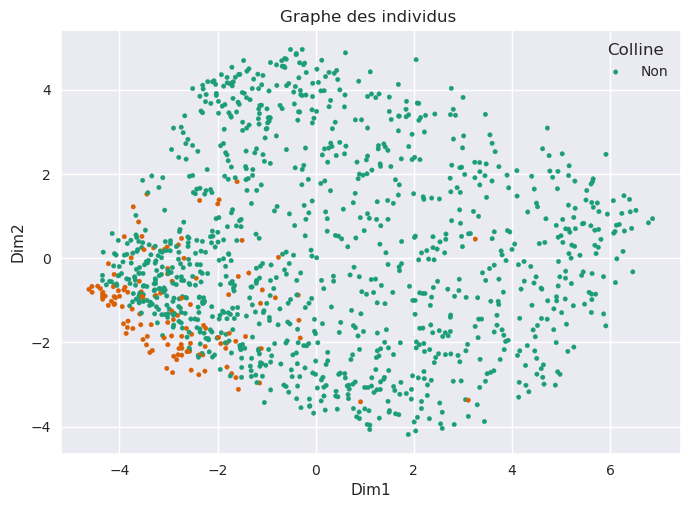

In [788]:

'''
# GRAPHE DES INDIVIDUS
# FUSIONNER BONUS DE COORD DANS LOADING

loading_with_hill= pd.concat([loading, coord.iloc[:, 2]], axis=1) #concatene hill avec le reste

X = loading_with_hill.iloc[:, :-1] # Features
y = loading_with_hill.iloc[:, -1] # Variable binaire fusionnée

# Standardisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réaliser une PCA sur le dataset A combiné
pca = PCA(n_components=2) # Nous voulons projeter sur le plan (composante1, composante2)
principal_components = pca.fit_transform(X_scaled)

# Créer un DataFrame pour les composantes principales
principal_df = pd.DataFrame(data=principal_components, columns=['Component 1', 'Component 2'])

# Ajouter la variable fusionnée comme une colonne supplémentaire
principal_df['Merged Value'] = y.values

# Afficher le graphe des individus projetés
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Component 1', y='Component 2', hue='Merged Value', data=principal_df, palette='Set1', s=50)
plt.title('Projection des individus sur les deux premières composantes principales')
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.legend(title='Valeur de "bonus"')
plt.grid(True)
plt.show()
'''


loading_with_hill = pd.concat([loading, coord.iloc[:, 2]], axis=1)

# Fit the PCA model on the combined data
pca = PCA()
loading_with_hill_pca = pca.fit_transform(loading_with_hill)

# Convert the PCA-transformed data to a DataFrame
loading_with_hill_pca_df = pd.DataFrame(loading_with_hill_pca[:, :2], columns=['Dim1', 'Dim2']) # Select only the first two principal components

# Plotting the scatter plot
palette = plt.get_cmap("Dark2")
couleurs = dict(zip(loading_with_hill["bonus"].drop_duplicates(), palette(range(2))))

plt.scatter(x='Dim1', y='Dim2', c=[couleurs[p] for p in loading_with_hill["bonus"]], data=loading_with_hill_pca_df, s=10)
plt.xlabel('Dim1')
plt.ylabel('Dim2')
plt.title('Graphe des individus ')
plt.legend(title='Colline',labels=['Non', 'Oui'])

plt.show()

Les individus localisés sur une colline sont regroupés sur le graphique. Ils sont corrélés négativement avec les dimensions 1 et 2 ce qui traduit le fait que ces stations sont en moyenne moins remplies que celles qui ne sont pas en altitude. De plus elles sont plutot utilisées pendant les horaires de repos.

Nous retenons donc de cette Analyse en Composante Principale que les usages des Velibs sont principalement dépendant des mobilités professionnelles et du cycle jour/nuit.

## KMEANS APPLIQUEE AUX DONNEES LOADING

Dans cette partie, nous tenterons de tirer des interprétations sur notre jeu de données à partir de la méthode de clustering KMeans. Nous tâcherons d'identifier des profils types de comportements des usagers et tenterons dans un premier temps de déterminer des classes sur le jeu de données loading puis de réaliser dans un premier temps l'ACP avant de classifier les individus. 

Une fois les données centrées réduites, il conviendra d'abord de déterminer le nombre de clusters à appliquer pour notre classification par KMeans. Pour cela nous nous attacherons à trouver la méthode optimisée avec le meilleur score pour notre méthode de clustering, à l'aide du score Silhouette et de la méthode du coude.

In [810]:
df=loading_data
# Standardisation des données
scaler = StandardScaler()
loading_standardized = scaler.fit_transform(df)

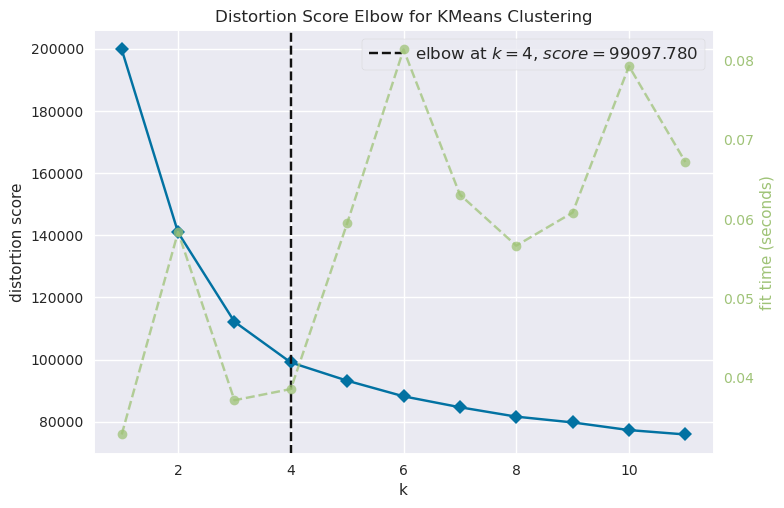

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [811]:
# Methode du coude Kmeans appliqué sur loading
kmeans = KMeans(init='k-means++',n_init=10, max_iter=100, random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1,12))

visualizer.fit(loading_standardized)    # Fit the data to the visualizer
visualizer.show() 

La méthode du coude ci-dessus nous permet de déduire qu'il faudrait conserver 4 clusters pour appliquer KMeans sur nos données. Cependant, on repère un nombre de clusters idéal très différent lorsque l'on tente d'optimiser le score silhouette.

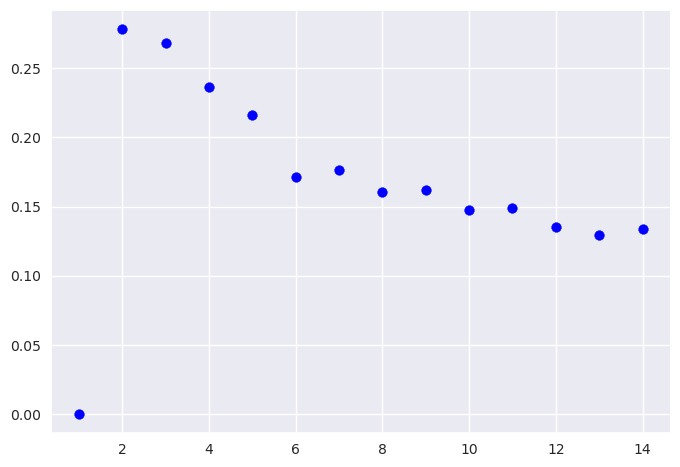

In [812]:
k_max = 15

silhouette = []
for k in range(2, k_max):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10,random_state=28).fit(loading_standardized)
    clusters_kmeans = kmeans.fit_predict(loading_standardized)
    silhouette.append( silhouette_score(loading_standardized, clusters_kmeans, metric='euclidean') )
silhouette = np.array(silhouette)
plt.scatter(1,0, color="blue")
plt.scatter(range(2, k_max), silhouette, color="blue")
plt.show()

Le score silhouette est en effet le plus élevé lorsque l'on sélectionne seulement deux clusters. Il serait alors intéressant de tester notre méthode de clustering KMeans sur deux classes puis sur 4 classes et voir ce que nous pouvons tirer de ces deux classifications.

Dans un premier temps, nous appliquons la méthode KMeans sur deux classes, et nous allons analyser si il existe des similitudes de profils entre les points des deux classes. C'est pourquoi nous comparerons les classes générées par kmeans par rapport à celles déterminées avec la variable qualitative "bonus".


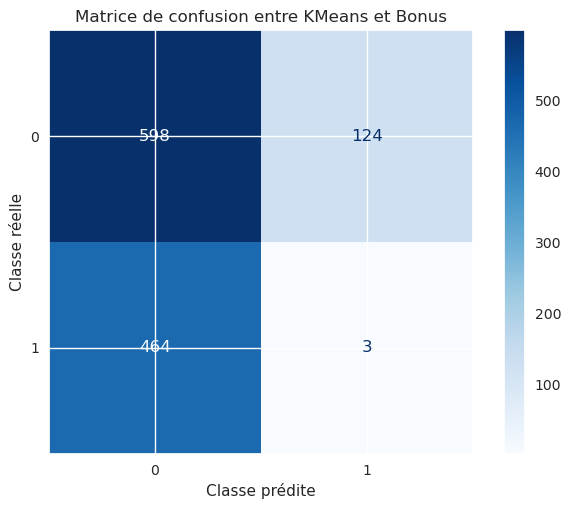

In [843]:
#label1 correspond aux classes KMEANS prédites issus du code ci desssus
# Matrice de confusion entre les classes KMeans et les classes issues de la variable qualitative
conf_matrix = confusion_matrix(labels1, loading_with_hill['bonus'])  # Remplacer labels1 par vos prédictions KMeans
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(loading_with_hill['bonus']))
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion entre KMeans et Bonus')
plt.show()

On remarque qu'appliquer KMeans sur deux classes ne suffit pas à identifier le profil types des stations situées sur une colline. La classification KMeans sur deux classes ne semble donc pas pertinent pour étudier les stations spécifiques situées en colline.

Cependant, la répartition des individus classifiés avec un KMeans sur 2 classes semble correspondre à la répartition des stations selon si leur remplissage moyen est supérieur à celle de la moyenne des stations ou non. Pour évaluer la pertinence de cette observation, nous allons donc comparer la répartition des points pour ces deux types de classifications et voir si l'on peut retrouver un lien et des similitudes entre les deux, d'abord à travers leur matrice de confusion, puis à travers les graphes des individus associé.

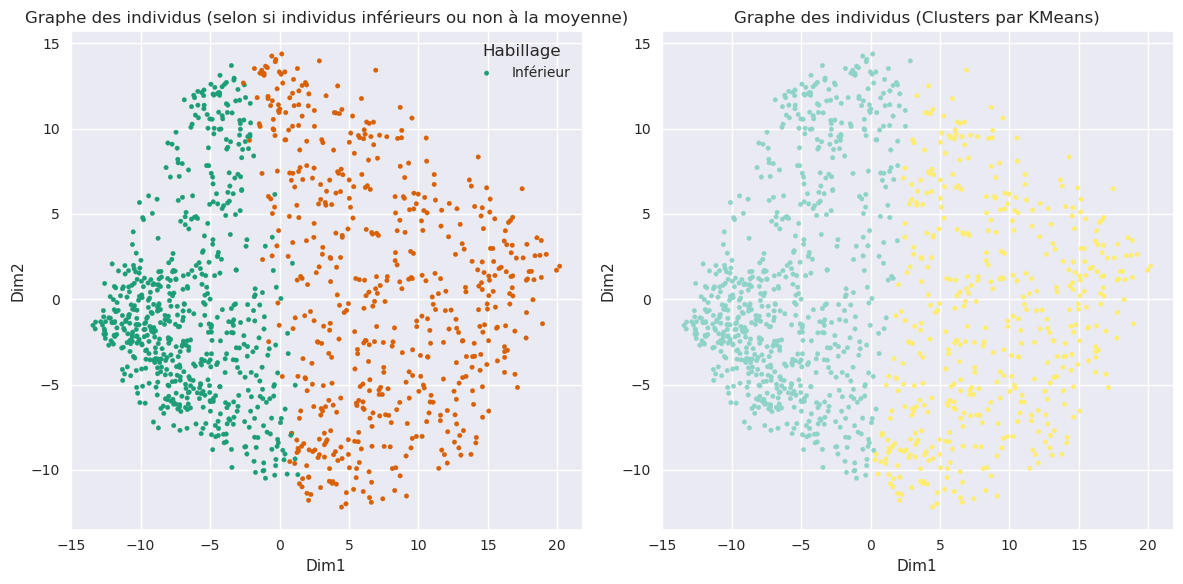

In [860]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))




# Deuxième graphique
df2 = df.copy()
data_to_scale2 = df2.drop(columns=['habillage']) if 'habillage' in df2.columns else df2.copy()
scaler2 = StandardScaler()
df_scaled2 = scaler2.fit_transform(data_to_scale2)

# Calculer les moyennes réduites
row_means = df_scaled2.mean(axis=1)
global_mean = df_scaled2.mean()

# Déterminer l'habillage basé sur les moyennes réduites
habillage = np.where(row_means < global_mean, 'Inférieur', 'Supérieur')

# Réaliser l'analyse en composantes principales (PCA)
pca2 = PCA()
pca_loading2 = pca2.fit_transform(df_scaled2)
df_pca2 = pd.DataFrame(pca_loading2[:, :2], columns=['Dim1', 'Dim2'])

# Définir la palette de couleurs
palette = plt.get_cmap("Dark2")
couleurs = dict(zip(np.unique(habillage), palette(range(2))))

# Tracer le graphe des individus selon l'habillage
axes[0].scatter(x='Dim1', y='Dim2', c=[couleurs[p] for p in habillage], data=df_pca2, s=10)
axes[0].set_xlabel('Dim1')
axes[0].set_ylabel('Dim2')
axes[0].set_title('Graphe des individus (selon si individus inférieurs ou non à la moyenne)')
axes[0].legend(title='Habillage', labels=['Inférieur', 'Supérieur'])

# Premier graphique
df1 = df.copy()
data_to_scale1 = df1.drop(columns=['habillage']) if 'habillage' in df1.columns else df1.copy()
scaler1 = StandardScaler()
df_scaled1 = scaler1.fit_transform(data_to_scale1)
n_clusters1 = 2
kmeans1 = KMeans(n_clusters=n_clusters1, init="k-means++", n_init=10, random_state=28)
kmeans1.fit(df_scaled1)
labels1 = kmeans1.predict(df_scaled1)
pca1 = PCA()
pca_loading1 = pca1.fit_transform(df_scaled1)
df_pca1 = pd.DataFrame(pca_loading1[:, :2], columns=['Dim1', 'Dim2'])
axes[1].scatter(x=df_pca1['Dim1'], y=df_pca1['Dim2'], c=labels1, cmap='Set3', s=10)
axes[1].set_xlabel('Dim1')
axes[1].set_ylabel('Dim2')
axes[1].set_title('Graphe des individus (Clusters par KMeans)')

'''
# Troisieme graphique
loading_with_hill = pd.concat([loading, coord.iloc[:, 2]], axis=1)

# Fit the PCA model on the combined data
pca = PCA()
loading_with_hill_pca = pca.fit_transform(loading_with_hill)

# Convert the PCA-transformed data to a DataFrame
loading_with_hill_pca_df = pd.DataFrame(loading_with_hill_pca[:, :2], columns=['Dim1', 'Dim2']) # Select only the first two principal components

# Plotting the scatter plot
palette = plt.get_cmap("Dark2")
couleurs = dict(zip(loading_with_hill["bonus"].drop_duplicates(), palette(range(2))))

axes[2].scatter(x='Dim1', y='Dim2', c=[couleurs[p] for p in loading_with_hill["bonus"]], data=loading_with_hill_pca_df, s=10)
axes[2].set_xlabel('Dim1')
axes[2].set_ylabel('Dim2')
axes[2].set_title('Graphe des individus ')
axes[2].legend(title='Colline',labels=['Non', 'Oui'])
'''

plt.tight_layout()
plt.show()

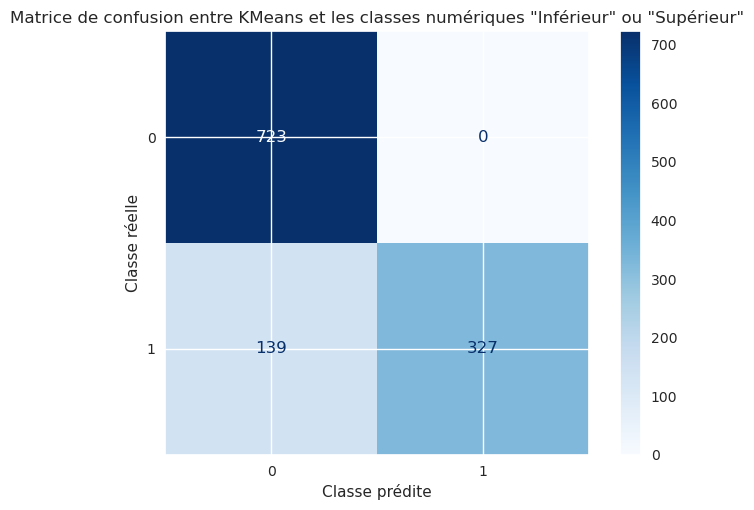

In [861]:
row_means = df_scaled1.mean(axis=1)
global_mean = data_to_scale1.values.mean()
habillage = np.where(row_means < global_mean, 'Inférieur', 'Supérieur')

# Matrice de confusion entre les étiquettes des clusters KMeans et les classes issues de la variable qualitative "Inférieure" ou "Supérieure"
labels1_str = labels1.astype(str)

# Matrice de confusion entre les étiquettes des clusters KMeans et les classes issues de la variable qualitative "Inférieure" ou "Supérieure"
mapping = {'Inférieur': 0, 'Supérieur': 1}
habillage_numeric = habillage.copy()
habillage_numeric = np.array([mapping[label] for label in habillage_numeric])

# Matrice de confusion entre les étiquettes des clusters KMeans et les classes numériques attribuées à "Inférieur" ou "Supérieur"
conf_matrix = confusion_matrix(labels1, habillage_numeric)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(habillage_numeric))
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion entre KMeans et les classes numériques "Inférieur" ou "Supérieur"')
plt.show()

On remarque beaucoup de similitudes entre les deux graphes et sur la table de contingence. Ainsi le clustering en 2 classes à l'aide de la méthode KMeans semble diviser les stations en deux selon si leur remplissage moyen est supérieur a la moyenne des stations ou non.




##Si on étudie le graphe à travers le prisme des heures, on remarque que la composante 1 semble davantage bien représenter les variables des plages horaires nocturnes et à l'inverse la variable 2 semble bien représenter les pages horaires du jour (corrélé positivement pour la fin de journée et négativement pour le début de journée)

Si l'on effectue la synthèse des observations sur les variables projetées sur les différentes composantes, on peut interpréter la composante 2 comme celle correspondant aux usages de la vie active (journées et monde professionel), et la composante 1 comme les périodes non ouvrés (weekend et nuit) où les comportements sont différents

# KMeans appliqué avec 4 clusters

In [ ]:
# Comparaison matrice de confusion et graphe Kmeans 4 classes et hill=1
# Projection sur lattitude et longitude du kmeans

# KMEANS APPLIQUEE A L'ACP



In [789]:
Kmeans_acp= KMeans()

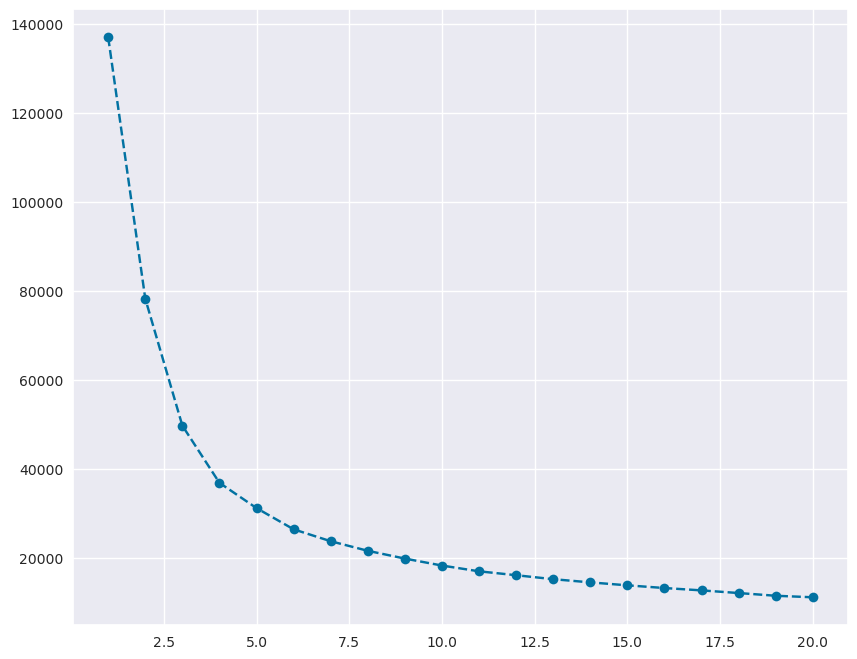

/usr/local/insa/anaconda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



[1 2 0 ... 1 2 0]


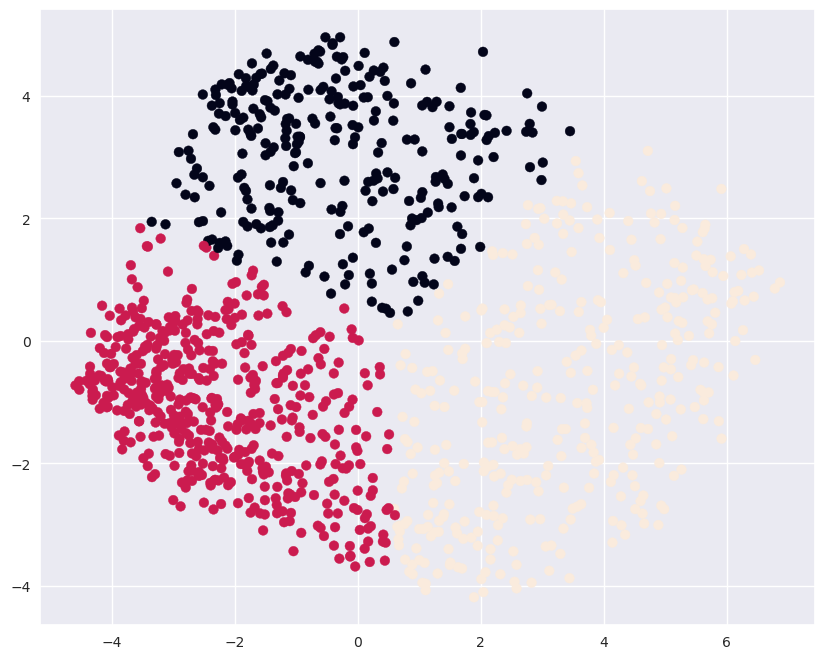

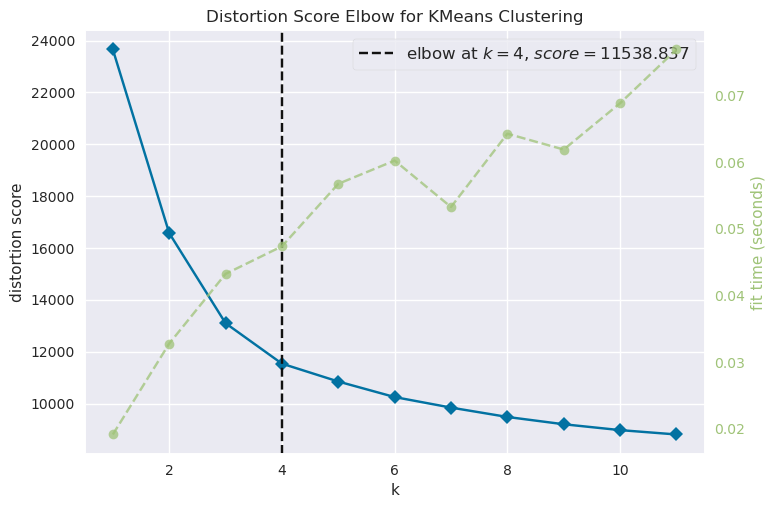

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [790]:
df=loading
# Standardisation des données
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df)


pca = PCA(n_components=3)

# Ajustement du PCA sur les données
pca.fit(segmentation_std)
score_pca=pca.transform(segmentation_std)

wcss =[]
for i in range(1,21):
    kmeans_pca= KMeans(n_clusters=i, init = "k-means++",n_init=10, random_state=42)
    kmeans_pca.fit(score_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1,21),wcss, marker ='o', linestyle = "--")
plt.show()


## elbow method avec yellowbrick
kmeans = KMeans(init='k-means++',n_init=10, max_iter=100, random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1,12))###Autre maniere expérimentale de faire kmeans
pca = PCA()
C=pca.fit(loading).transform(loading)

clust=KMeans(n_clusters=3)
clust.fit(loading)
classe=clust.labels_
print(classe)
plt.figure(figsize=(10,8))
plt.scatter(C[:,0], C[:,1], c=classe)
plt.show()

visualizer.fit(loading) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

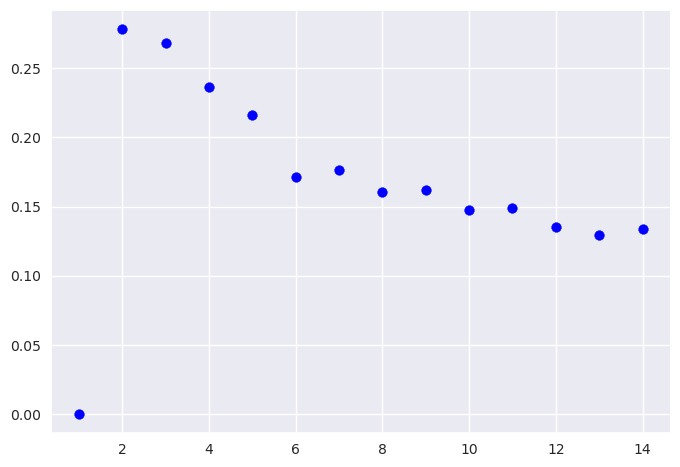

In [791]:
k_max = 15
df=loading
scaler = StandardScaler()
loading_standardized=scaler.fit_transform(df)



silhouette = []
for k in range(2, k_max):
    kmeans = KMeans(n_clusters=k, init="k-means++", nKMeans_init=10,random_state=28).fit(score_pca) # pas sur
    clusters_kmeans = kmeans.fit_predict(loading_standardized)
    silhouette.append( silhouette_score(loading_standardized, clusters_kmeans, metric='euclidean') )
silhouette = np.array(silhouette)
plt.scatter(1,0, color="blue")
plt.scatter(range(2, k_max), silhouette, color="blue")
plt.show()

D'après le score selon le nombre de de classes retenues, il semble pertinent de garder 4 classes pour notre étude d'après la méthode du coude contre 2 d'après le score silhouette. On remarque que le nombre de classes à conserver est identique avec ou sans ACP.

In [862]:
df_segm_pca_kmeans=pd.concat([df.reset_index(drop=True), pd.DataFrame(score_pca)],axis=1)

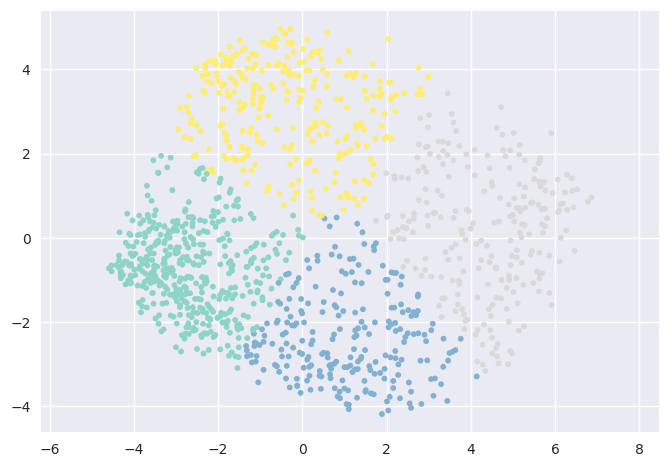

In [866]:
df=loading
pca = PCA()
pca.fit(df)
score_pca = pca.transform(df)

# Effectuer le clustering K-Means


n_clusters = 4
kmeans_pca = KMeans(n_init = 10,n_clusters=n_clusters, init="k-means++", random_state=28)
kmeans_pca.fit(score_pca)

# Ajouter les étiquettes de segment à df
df_segm_pca_kmeans['Segment K-Means PCA'] = kmeans_pca.labels_


 

#### A l'aide du tp mars
def plotKmeans(kmeans, data, n_clusters=4):
    kmeans.fit(data)
    clusters_kmeans = kmeans.predict(data)

    ax = plt.gca()
    ax.axis('equal')
    cmap = plt.get_cmap('Set3', n_clusters)

    # plot the input data
    ax.scatter(data[:, 0], data[:, 1], c=clusters_kmeans, s=10, linewidths=1, cmap=cmap)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    #radius = [cdist(data[clusters_kmeans == i], [center]).max() for i, center in enumerate(centers)]
    #for i in range(n_clusters):
        #ax.add_patch(plt.Circle(centers[i], radius[i], fc=cmap.colors[i], alpha=0.3))
plotKmeans(KMeans(n_init = 10,n_clusters=4), score_pca, n_clusters=7)

Lorsque l'on projette sur le plan (dim1, dim2) sur le graphe des individus les stations classifiées, on retrouve la même répartition de points que pour la méthode KMeans appliqué aux données directement. De plus, il semble se dessiner des profils types de classes légérement mieux identifiables que pour les KMeans sur les données précédentes. On remarque ainsi qu'une classe semble approximativement se superposer aux stations ayant la caractértistique "bonus=1" et que d'autres classes ont un profil type de comportement en fonction des heures et des jours de la journée. Nous pouvons davantage observer ceci sur le graphe suivant.


In [794]:
### RECUPERER LES POINTS DU CLUSTER 4 ET LES INTERPRETER
segment_3_indices = df_segm_pca_kmeans.index[df_segm_pca_kmeans['Segment K-Means PCA'] == 3]

# Sélectionner les lignes correspondantes dans le DataFrame original df
loading_classe4 = loading.iloc[segment_3_indices] #classe 4 = pts du segment 3
coord_classe4=coord.iloc[segment_3_indices]
loading_data_classe4=loading_classe4.to_numpy()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
s, n = 10, len(hours)

# Création de la fonction qui génère le graphique en fonction de l'heure et du jour choisis
def plot_hour_day(hour, day): ## je suggere de mettre coord et loading_data en params pour pouvoir y toucher et pas avoir a copier
    fig, ax = plt.subplots(figsize=(s, s))
    im = ax.scatter(coord_classe4.longitude, coord_classe4.latitude, c=loading_data_classe4[:, hour + 24*(days.index(day))], cmap=cm.plasma_r)
    #loading_data = loading.to_numpy()
    ax.set_title('Stations loading - {} {} h'.format(day, hour), fontsize=25)
    ax.set_xlabel('Longitude', fontsize=20)
    ax.set_ylabel('Latitude', fontsize=20)
    ax.tick_params(axis='both', labelsize=15)
    plt.colorbar(im, ax=ax)
    plt.show()


# Création de l'interface interactive avec deux curseurs pour choisir l'heure et le jour
interact(plot_hour_day, hour=IntSlider(min=1, max=24, step=1, value=1), day=Dropdown(options=days, value='Monday', description='Day:'))

interactive(children=(IntSlider(value=1, description='hour', max=24, min=1), Dropdown(description='Day:', opti…

<function __main__.plot_hour_day(hour, day)>

Tracer la répartition dans l'espace des stations classifiées par méthode des KMeans permet d'identifier clairement que la première classe regroupe principalement les stations peu remplies que l'on retrouve sur les bords autour de du motif quotidien en "banane" du remplissage et qui ont une dynamique similaire. De même, on reconnait plutôt bien les stations se situant sur une colline dans les stations repérées sur la classe 4.

La "banane" concentrant la plupart des stations très dynamiques et remplies aux memes heures de la journée semble correspondre surtout aux points du dernier cluster

In [795]:
# Généralisation : identification classe par classe des types de répartitions des points sur une multitude d'instants

df=loading
pca = PCA()
pca.fit(df)
score_pca = pca.transform(df)
n_clusters = 4
kmeans_pca = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10,random_state=28)
kmeans_pca.fit(score_pca)
df_segm_pca_kmeadf = loading['Segment K-Means PCA'] = kmeans_pca.labels_

# 0
segment_indices0 = df_segm_pca_kmeans.index[df_segm_pca_kmeans['Segment K-Means PCA'] == 0]
loading_classe0= loading.iloc[segment_indices0]
coord_classe0 = coord.iloc[segment_indices0]
loading_data_classe0 = loading_classe0.to_numpy()
 
# 1
segment_indices1 = df_segm_pca_kmeans.index[df_segm_pca_kmeans['Segment K-Means PCA'] == 1]
loading_classe1= loading.iloc[segment_indices1]
coord_classe1 = coord.iloc[segment_indices1]
loading_data_classe1 = loading_classe1.to_numpy()

# 2
segment_indices2 = df_segm_pca_kmeans.index[df_segm_pca_kmeans['Segment K-Means PCA'] == 2]
loading_classe2= loading.iloc[segment_indices2]
coord_classe2 = coord.iloc[segment_indices2]
loading_data_classe2 = loading_classe2.to_numpy()

# 3
segment_indices3 = df_segm_pca_kmeans.index[df_segm_pca_kmeans['Segment K-Means PCA'] == 3]
loading_classe3= loading.iloc[segment_indices3]
coord_classe3 = coord.iloc[segment_indices3]
loading_data_classe3 = loading_classe3.to_numpy()


def plot_hour_day(hour, day): # Passer la valeur de i comme argument
    
    fig, ax = plt.subplots(2, 2)
    


    im1 = ax[0,0].scatter(coord_classe0.longitude, coord_classe0.latitude, c=loading_data_classe0[:, hour + 24*(days.index(day))], cmap=cm.plasma_r)
    ax[0,0].set_title('Stations loading - {} {} h'.format(day, hour)+' classe n°'+str(1), fontsize=6) # Utiliser la valeur de cluster
    ax[0,0].set_xlabel('Longitude', fontsize=5)
    ax[0,0].set_ylabel('Latitude', fontsize=5)
    ax[0,0].tick_params(axis='both', labelsize=4)
    #plt.colorbar(im1, ax[0,0]=ax[0,0])
    


    im2 = ax[0,1].scatter(coord_classe1.longitude, coord_classe1.latitude, c=loading_data_classe1[:, hour + 24*(days.index(day))], cmap=cm.plasma_r)
    ax[0,1].set_title('Stations loading - {} {} h'.format(day, hour)+' classe n°'+str(2), fontsize=6) # Utiliser la valeur de cluster
    ax[0,1].set_xlabel('Longitude', fontsize=5)
    ax[0,1].set_ylabel('Latitude', fontsize=5)
    ax[0,1].tick_params(axis='both', labelsize=4)
    #plt.colorbar(im2, ax[0,1]=ax[0,1])
    


    im3 = ax[1,0].scatter(coord_classe2.longitude, coord_classe2.latitude, c=loading_data_classe2[:, hour + 24*(days.index(day))], cmap=cm.plasma_r)
    ax[1,0].set_title('Stations loading - {} {} h'.format(day, hour)+' classe n°'+str(3), fontsize=6) # Utiliser la valeur de cluster
    ax[1,0].set_xlabel('Longitude', fontsize=5)
    ax[1,0].set_ylabel('Latitude', fontsize=5)
    ax[1,0].tick_params(axis='both', labelsize=4)
    #plt.colorbar(im3, ax[1,0]=ax[1,0])
    

    im4 = ax[1,1].scatter(coord_classe3.longitude, coord_classe3.latitude, c=loading_data_classe3[:, hour + 24*(days.index(day))], cmap=cm.plasma_r)
    ax[1,1].set_title('Stations loading - {} {} h'.format(day, hour)+' classe n°'+str(4), fontsize=6) # Utiliser la valeur de cluster
    ax[1,1].set_xlabel('Longitude', fontsize=5)
    ax[1,1].set_ylabel('Latitude', fontsize=5)
    ax[1,1].tick_params(axis='both', labelsize=4)
    #plt.colorbar(im4, ax[1,1]=ax[1,1])
    
    plt.show()
    
interact(plot_hour_day, hour=IntSlider(min=1, max=24, step=1), day=Dropdown(options=days, description='Day:'))

interactive(children=(IntSlider(value=1, description='hour', max=24, min=1), Dropdown(description='Day:', opti…

<function __main__.plot_hour_day(hour, day)>

Il semble donc que la méthode des KMeans appliquée à l'Analyse en Composante Principale dégage pour 4 classes 4 types de comportement différents. Il semble notamment que la classe 4 est celle qui regroupe les stations avec le plus de remplissage au cours du temps pratiquement en permanence. Et par opposition la classe 1 et 3 regroupent celles avec le moins de remplissage. Cela corrobhore notre interprétations de l'ACP. En effet, la classe 4 est celle qui maximise la composante 1 tandis que la classe 1 la minimise. Cela met donc bien en relief que la composante 1 correspond au remplissage moyen des stations. D'autre part, on remarque qu'alors que la classe 1 semble voir le remplissage de ses stations très corrélé avec l'heure de la journée, la classe 3 semble également réunir de stations à un remplissage relativement faible mais dont le remplissage demeure stable au cours du temps et des jours. De la même manière que la classe 3, la classe 2 conserve aussi des taux de remplissages similaires en fonction de heures, mais avec un pourcentage plus important.

Et l'on remarque qu'aucun de ces profils types caractéristiques semble lié aux stations sur une colline qui ont une répartition particulière dans le plan

Pour 4 clusters interprétations :
-classe 1
-classe 2
-classe 3
-classe 4 : semble tres remplie la nuit et presque totalement non remplie le jour

# Kmeans appliqué directement sur les données

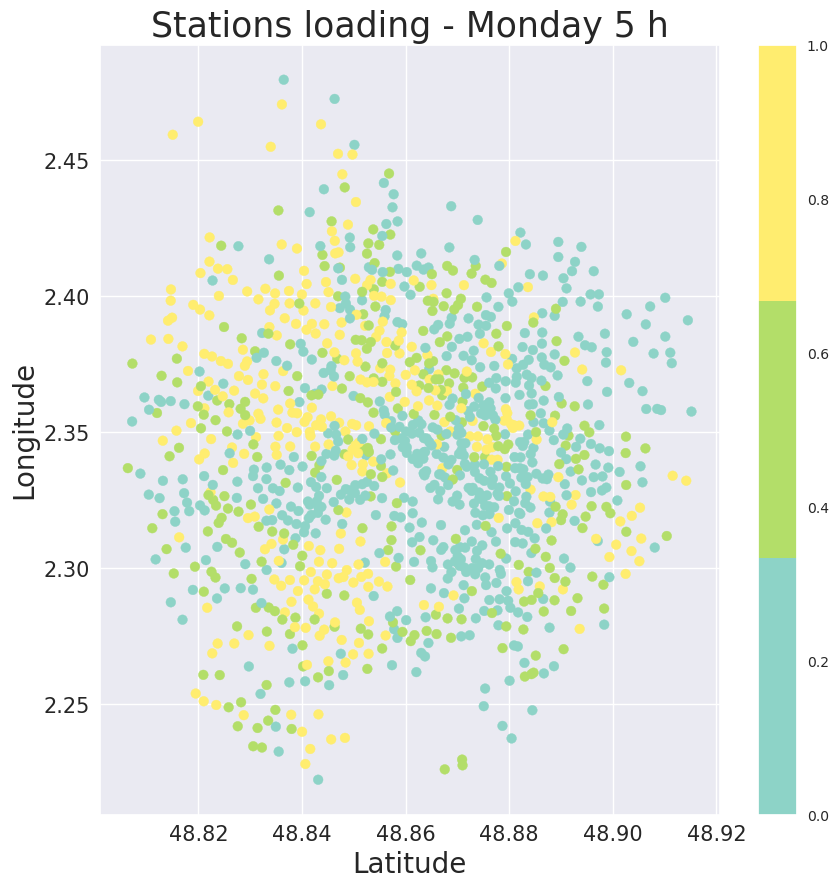

In [799]:
n_clusters=3
kmeans.fit(loading_data)
clusters_kmeans = kmeans.predict(loading_data)

#Special attention will be paid to the first point. In the first instance, a Ward linkage can be used.ax = plt.gca()
ax.axis('equal')
cmap = plt.get_cmap('Set3', n_clusters)

hours = np.arange(0, 24)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
s, n = 10, len(hours)

# Création de la fonction qui génère le graphique en fonction de l'heure et du jour choisis
def plot_hour_day(hour, day):
    fig, ax = plt.subplots(figsize=(s, s))
    im = ax.scatter(coord.latitude, coord.longitude, c=loading_data[:, hour + 24*(days.index(day))], cmap=cmap)
    #loading_data = loading.to_numpy()
    ax.set_title('Stations loading - {} {} h'.format(day, hour), fontsize=25)
    ax.set_xlabel('Latitude', fontsize=20)
    ax.set_ylabel('Longitude', fontsize=20)
    
    ax.tick_params(axis='both', labelsize=15)
    plt.colorbar(im, ax=ax)
    plt.show()
plot_hour_day(5,'Monday')

In [867]:
df=loading
n_clusters = 4
kmeans.fit(df)
kmeans.predict(df)
df_labels = loading['Segment K-Means '] = kmeans.labels_



# 0
segment_indices0 = df_labels.index[df_labels['Segment K-Means '] == 0]
loading_classe0= loading.iloc[segment_indices0]
coord_classe0 = coord.iloc[segment_indices0]
loading_data_classe0 = loading_classe0.to_numpy()
 
# 1
segment_indices1 = df_labels.index[df_segm_pca_kmeans['Segment K-Means '] == 1]
loading_classe1= loading.iloc[segment_indices1]
coord_classe1 = coord.iloc[segment_indices1]
loading_data_classe1 = loading_classe1.to_numpy()

# 2
segment_indices2 = df_labels.index[df_segm_pca_kmeans['Segment K-Means '] == 2]
loading_classe2= loading.iloc[segment_indices2]
coord_classe2 = coord.iloc[segment_indices2]
loading_data_classe2 = loading_classe2.to_numpy()

# 3
segment_indices3 = df_labels.index[df_segm_pca_kmeans['Segment K-Means '] == 3]
loading_classe3= loading.iloc[segment_indices3]
coord_classe3 = coord.iloc[segment_indices3]
loading_data_classe3 = loading_classe3.to_numpy()


def plot_hour_day(hour, day): # Passer la valeur de i comme argument
    
    fig, ax = plt.subplots(2, 2)
    


    im1 = ax[0,0].scatter(coord_classe0.longitude, coord_classe0.latitude, c=loading_data_classe0[:, hour + 24*(days.index(day))], cmap=cm.plasma_r)
    ax[0,0].set_title('Stations loading - {} {} h'.format(day, hour)+' classe n°'+str(1), fontsize=6) # Utiliser la valeur de cluster
    ax[0,0].set_xlabel('Longitude', fontsize=5)
    ax[0,0].set_ylabel('Latitude', fontsize=5)
    ax[0,0].tick_params(axis='both', labelsize=4)
    #plt.colorbar(im1, ax[0,0]=ax[0,0])
    


    im2 = ax[0,1].scatter(coord_classe1.longitude, coord_classe1.latitude, c=loading_data_classe1[:, hour + 24*(days.index(day))], cmap=cm.plasma_r)
    ax[0,1].set_title('Stations loading - {} {} h'.format(day, hour)+' classe n°'+str(2), fontsize=6) # Utiliser la valeur de cluster
    ax[0,1].set_xlabel('Longitude', fontsize=5)
    ax[0,1].set_ylabel('Latitude', fontsize=5)
    ax[0,1].tick_params(axis='both', labelsize=4)
    #plt.colorbar(im2, ax[0,1]=ax[0,1])
    


    im3 = ax[1,0].scatter(coord_classe2.longitude, coord_classe2.latitude, c=loading_data_classe2[:, hour + 24*(days.index(day))], cmap=cm.plasma_r)
    ax[1,0].set_title('Stations loading - {} {} h'.format(day, hour)+' classe n°'+str(3), fontsize=6) # Utiliser la valeur de cluster
    ax[1,0].set_xlabel('Longitude', fontsize=5)
    ax[1,0].set_ylabel('Latitude', fontsize=5)
    ax[1,0].tick_params(axis='both', labelsize=4)
    #plt.colorbar(im3, ax[1,0]=ax[1,0])
    

    im4 = ax[1,1].scatter(coord_classe3.longitude, coord_classe3.latitude, c=loading_data_classe3[:, hour + 24*(days.index(day))], cmap=cm.plasma_r)
    ax[1,1].set_title('Stations loading - {} {} h'.format(day, hour)+' classe n°'+str(4), fontsize=6) # Utiliser la valeur de cluster
    ax[1,1].set_xlabel('Longitude', fontsize=5)
    ax[1,1].set_ylabel('Latitude', fontsize=5)
    ax[1,1].tick_params(axis='both', labelsize=4)
    #plt.colorbar(im4, ax[1,1]=ax[1,1])
    
    plt.show()
    
interact(plot_hour_day, hour=IntSlider(min=1, max=24, step=1), day=Dropdown(options=days, description='Day:'))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

Si on étudie le graphe à travers le prisme des heures, on remarque que la composante 1 semble davantage bien représenter les variables des plages horaires nocturnes et à l'inverse la variable 2 semble bien représenter les pages horaires du jour (corrélé positivement pour la fin de journée et négativement pour le début de journée)

Si l'on effectue la synthèse des observations sur les variables projetées sur les différentes composantes, on peut interpréter la composante 2 comme celle correspondant aux usages de la vie active (journées et monde professionel), et la composante 1 comme les périodes non ouvrés (weekend et nuit) où les comportements sont différents